In [1]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from itertools import chain, combinations
import random as rnd
import time
import pylab
import math
import random as rnd
import collections
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import multiprocessing as mp
import pickle
import random
from statistics import mean
import time
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In [13]:
## takes a graph, and  a cost vector: returns a list cost of nodes

# def Cost_vect(G,C):
#     new_c=[]
#     for node in G.nodes():
#         cost=[]
#         z = nx.single_source_shortest_path_length(G,node,2)
#         for i in z:
#             if z[i]==1:
#                 cost.append(C[i])
#         new_c.append(sum(cost))
#     return new_c


# # Calculates node utility by taking the network (G), benefit vector and Cost matrix (this is used in the next function)
# def node_utility_general(node,G,b,C,depth=3):
#     z = nx.single_source_shortest_path_length(G,node,depth)
#     benefit = sum ( [ b[z[k]-1] for k in z]  )
#     cost = Cost_vect(G,C)[node]
#     return round(benefit - cost,2)


#__ takes a graph, and a cost matrix, and returns the cost of each node as a vector
def Cost_matrix(G,C):
#     adj_mat=nx.to_numpy_matrix(G)
#     mul_mat=np.matmul(C,np.transpose(adj_mat))
#     C_list=mul_mat.diagonal()
#     return C_list.tolist()[0]

    adj_mat = nx.to_numpy_array(G)  
    mul_mat = np.matmul(C, np.transpose(adj_mat))  
    C_list = mul_mat.diagonal()  
    return C_list.tolist()

# Calculates node utility by taking the network (G), benefit vector and Cost matrix (this is used in the next function)
def node_utility_general(node,G,b,C,depth=3):
    z = nx.single_source_shortest_path_length(G,node,depth)
    benefit = sum ( [ b[z[k]-1] for k in z]  )
    cost = Cost_matrix(G,C)[node]
    return round(benefit - cost,2)

# Returns all the node utilities
def all_utils_general(g,b,C,depth=3):
    node_utils= [node_utility_general(k,g,b,C,depth) for k in g.nodes()]
    return node_utils

#Calculates network utilities ofr each node and sets them as node attributes
def set_network_util_attributes(g,b,C,depth=3):
    utils=all_utils_general(g,b,C,depth=depth)
    dict_util={}
    for i in g.nodes():
        dict_util[i]=round(utils[i],2)
    nx.set_node_attributes(g, dict_util, 'utility')   
    return g


In [15]:
#STABLE NETWORK GENERATION 

""" We seperate the sources of instability in networks into two categories: Frustration and envy. Frustration is when one node
wants to remove one of its links. Envy is when two nodes want to form a link that currently doesn't exist. We look at the impact of each of these facots seperately
by generating no frustration and no envy networks. Then we combine the two and find stable networks."""

#4 __for a given node, v, returns neighbors to whom v wants to disconnect the tie, and the difference in utility that is saved.
def frust_test_general(g,v,b,cx,depth=3):
    u_0 = node_utility_general(v,g,b,cx,depth)
    bad_neighbors=[]
    for ng in g.neighbors(v):
        g_tmp = g.copy()
        g_tmp.remove_edge(v,ng)
        u_new = node_utility_general(v,g_tmp,b,cx,depth)
        if u_new > u_0:
            bad_neighbors.append([v,ng,u_new-u_0])
    return bad_neighbors


#5 Takes network and cost and benefit parameters and returns the list of frustrated nodes
def total_frust_list_general(g,b,c,depth=3):
    total_list=[]
    for v in g.nodes():
        total_list+=frust_test_general(g,v,b,c,depth)
    return total_list

#6 Takes a network as an input, and returns all the links that both ends would agree with adding (envy list)
def missed_opts_general(g,b,cx,depth=3):
    node_utils= [node_utility_general(k,g,b,cx,depth) for k in g.nodes()]
    missing_links=[]
    for e in list(nx.edges(nx.complement(g))):
        g_tmp=g.copy()
        g_tmp.add_edge(*e)
        us_shift=node_utility_general(e[0],g_tmp,b,cx,depth)-node_utils[e[0]]
        ud_shift=node_utility_general(e[1],g_tmp,b,cx,depth)-node_utils[e[1]]
        if ((us_shift>=0 and ud_shift>=0) and (abs(us_shift)+abs(ud_shift)!= 0)):
            missing_links.append(e)
    return missing_links

# Network's "excess links"
#7 Takes a network, starts removing edges till it gets to a no-frustration network
def find_no_frustration_network_general(g,b,cx,depth=3,M=1000):
    f_list=total_frust_list_general(g,b,cx,depth)
    g_tmp=g.copy()
    while ((f_list) and (M>0)):
        e_rem=rnd.choice(f_list)
        g_tmp.remove_edge(e_rem[0],e_rem[1])
        f_list=total_frust_list_general(g_tmp,b,cx,depth)
        M=M-1
    return g_tmp,M


# Network's "missing links"
#8 Takes a network, starts adding links till it gets to a no-envy network
def find_no_envy_network_general(g,b,cx,depth=3,M=1000):
    en_list=missed_opts_general(g,b,cx,depth)
    g_tmp=g.copy()
    while ((en_list) and (M>0)):
        e_add=rnd.choice(en_list)
        g_tmp.add_edge(*e_add)
        en_list=missed_opts_general(g_tmp,b,cx,depth)
        #print(len(en_list))
        M=M-1
    return g_tmp,M

"""Here we combine the two factors to find stable networks. 
The following function takes network parameters, first calculates and sets utilities of each node. 
Then create a list of frustrated nodes and envy-generating links. Then at each time step moves one
step towards lowering envy and one step towards reducing frustration (M determines the number of steps in each process).
depth is the maximum distance for which node payoffs are calculated."""

def find_stable_network_general(g,b,cx,depth=3,N=1000,M=1):
    Steps=N
    set_network_util_attributes(g,b,cx,depth=depth)
    g_sequence=[]
    gt=g.copy()
    L1=total_frust_list_general(gt,b,cx,depth)
    L2=missed_opts_general(gt,b,cx,depth)
    while ((len(L1)>0 or (len(L2)>0)) and (N>0)):
        g_no_frust,Mf=find_no_frustration_network_general(gt,b,cx,depth,M)
        g_no_envy,Me=find_no_envy_network_general(g_no_frust,b,cx,depth,M)
        gt=g_no_envy
        L1=total_frust_list_general(gt,b,cx)
        L2=missed_opts_general(gt,b,cx)
        N=N-1
        set_network_util_attributes(gt,b,cx,depth=depth)
        g_sequence.append(gt)
        #print(N)
    return gt,Steps-N,g_sequence

In [16]:
"""The following 3 functions are related to the efficient network generation of the special case of seperable cost"""

#start with a cost vector (Cvec)
def seperable_cost(Cvec):
    n=len(Cvec)
    CM=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            CM[i,j]=Cvec[i]
    return CM

#returns the total utility (the assumption node utilities are already registered in the network)

def total_utility(G):
    U=0
    for i in G.nodes():
        U+=G.nodes()[i]['utility']
    return U

# This reutnrs the unique effiecnet network (the algorithm is based on a paper (Heydari, Mosleh (2015))) 
def seperable_efficient_network(b,C):
    n=len(C)
    G=nx.empty_graph(n)
    m=n
    RHS=C[0]-2*b[0]
    print('RHS',RHS)
    LHS=2*(m-2)*b[1]-C[m-1]
    print('LHS',LHS)
    while ((LHS >= RHS) and (m > 1)):
        print('this is m',m)
        LHS=2*(m-2)*b[1]-C[m-1]
        print('LHS',LHS)
        m=m-1
        
    if m==n:
        print('No efficient network exists!')
    for i in range(1,n-m+1):
        G.add_edge(0,i)
        for j in range(i+1,n-m+1):
            if (b[0]-b[1]) >= 0.5*(C[i]+C[j]):
                G.add_edge(i,j)
                print(i,j)
    print('number of isolated nodes in the efficient network',m-1)
    return G,m

In [17]:
def net_characteristics(network_list):
            for each in network_list:
                all_diameters.append(nx.diameter(each))
                net_diameter= nx.diameter(each)
                diameter.append(net_diameter)               
                degree_cent=nx.degree_centrality(each)
                ave_degree_cent = sum(degree_cent.values()) / len(degree_cent)
                degree.append(ave_degree_cent)
                
                eigenvector_cent = nx.eigenvector_centrality(each)
                ave_Eigen_cent = sum(eigenvector_cent.values()) / len(eigenvector_cent)
                eigen.append(ave_Eigen_cent)
                
                betweenness_cent = nx.betweenness_centrality(each)
                ave_betweenness_cent = sum(betweenness_cent.values()) / len(betweenness_cent)
                between.append(ave_betweenness_cent)
                
                clustering_coeff = nx.average_clustering(each)
                cluster.append(clustering_coeff) 
            return all_diameters and util and all_utilities and degree and eigen and between and cluster and diameter

        
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)
        
def nodes_connected(u, v):
    return u in G.neighbors(v)

In [18]:
#net appearance:

def draw (G):
    node_labels = nx.get_node_attributes(G,'utility')
    color_map2=[]
    for node in G:
        if G.degree(node)<4:
            color_map2.append('cadetblue')
        else: color_map2.append('goldenrod')
    nx.draw(G,pos=nx.spring_layout(G), node_size=1500, width=3, font_size=16, node_color=color_map2,with_labels=True)
    plt.show()
    return color_map2

In [ ]:
# EDGE REMOVAL disturbance: stable network generation functions:

#4 __for a given node, v, returns neighbors to whom v wants to disconnect the tie, and the difference in utility that is saved.
def frust_test_general2(g,v,b,cx,e1,e2,depth=3):
    u_0=node_utility_general(v,g,b,cx,depth)
    bad_neighbors=[]
    for ng in g.neighbors(v):
        g_tmp=g.copy()
        g_tmp.remove_edge(v,ng)
        u_new = node_utility_general(v,g_tmp,b,cx,depth)
        if u_new > u_0:
            bad_neighbors.append([v,ng,u_new-u_0])
        if v in e1 and ng in e2:
            bad_neighbors.append([v,ng,u_new-u_0])
        if v in e2 and ng in e1:
            bad_neighbors.append([v,ng,u_new-u_0])
            
    return bad_neighbors

#5 Takes network and cost and benefit parameters and returns the list of frustrated nodes
def total_frust_list_general2(g,b,c,e1,e2,depth=3):
    total_list=[]
    for v in g.nodes():
        total_list+=frust_test_general2(g,v,b,c,e1,e2,depth)
    return total_list

#6 Takes a network as an input, and returns all the links that both ends would agree with adding (envy list)
def missed_opts_general2(g,b,cx,e1,e2,depth=3):
    node_utils= [node_utility_general(k,g,b,cx,depth) for k in g.nodes()]
    missing_links=[]
    for e in list(nx.edges(nx.complement(g))):
        for n in e1:
            for m in e2:
                if n !=e[0] or m!=e[1]:
                    g_tmp=g.copy()
                    g_tmp.add_edge(*e)
                    us_shift=node_utility_general(e[0],g_tmp,b,cx,depth)-node_utils[e[0]]
                    ud_shift=node_utility_general(e[1],g_tmp,b,cx,depth)-node_utils[e[1]]
                    if ((us_shift>=0 and ud_shift>=0) and (abs(us_shift)+abs(ud_shift)!= 0)):
                        missing_links.append(e)
    return missing_links

#7 Takes a network, starts removing edges till it gets to a no-frustraction network
def find_no_frustration_network_general2(g,b,cx,e1,e2,depth=3,M=1000):
    f_list=total_frust_list_general2(g,b,cx,e1,e2,depth)
    g_tmp=g.copy()
    while ((f_list) and (M>0)):
        e_rem=rnd.choice(f_list)
        g_tmp.remove_edge(e_rem[0],e_rem[1])
        f_list=total_frust_list_general2(g_tmp,b,cx,e1,e2,depth)
        M=M-1
    return g_tmp,M

#8 Takes a network, starts adding links till it gets to a no-envy network
def find_no_envy_network_general2(g,b,cx,e1,e2,depth=3,M=1000):
    en_list=missed_opts_general2(g,b,cx,e1,e2,depth)
    g_tmp=g.copy()
    while ((en_list) and (M>0)):
        e_add=rnd.choice(en_list)
        g_tmp.add_edge(*e_add)
        en_list=missed_opts_general2(g_tmp,b,cx,e1,e2,depth)
        #print(len(en_list))
        M=M-1
    return g_tmp,M

def find_stable_network_general2(g,b,cx,e1,e2,depth=3,N=1000,M=1):
    Steps=N
    set_network_util_attributes(g,b,cx,depth=depth)
    g_sequence=[]
    gt=g.copy()
    L1=total_frust_list_general2(gt,b,cx,e1,e2,depth)
    L2=missed_opts_general2(gt,b,cx,e1,e2,depth)
    while ((len(L1)>0 or (len(L2)>0)) and (N>0)):
        g_no_frust,Mf=find_no_frustration_network_general2(gt,b,cx,e1,e2,depth,M)
        g_no_envy,Me=find_no_envy_network_general2(g_no_frust,b,cx,e1,e2,depth,M)
        gt=g_no_envy
        L1=total_frust_list_general2(gt,b,cx,e1,e2)
        L2=missed_opts_general2(gt,b,cx,e1,e2)
        N=N-1
        set_network_util_attributes(gt,b,cx,depth=depth)
        g_sequence.append(gt)
        #print(N)
    return gt,Steps-N,g_sequence

In [19]:
#SIMULATIONS: Disturbance Classes

class Disturbance_b:
    def __init__(self, G, b, cvec):
        self.G=G
        self.b=b
        self.cvec=cvec
        
        
    # benefit decrease:

    def benefit_disturbance (self):
        util_list=[]
        b_recovery_rate=[]
        b_stable_rate=[]
        b_collapse_rate=[]
        
        CMSj = seperable_cost(self.cvec)
        ben = self.b.copy()
        
        ben[0]=ben[0]+0.2
        ben[1]=ben[1]-0.5
        ben=sorted(ben, reverse=True)
    
        Lg=all_utils_general(self.G,ben,CMSj)
        b_u2= sum(Lg)
        util_list.append(b_u2)
        print("network utility after disturbance(benefit):", b_u2)
        b_G2=self.G
        draw(b_G2)
        
        #We want the efficient net here as well:
        print("Start efficient designing:")
        eff,m=seperable_efficient_network(ben,cvec)
        print("THIS IS YOUR EFFICIENT NET AFTER DISTURBANCE:")
        draw(eff)
        LLL=all_utils_general(eff,ben,CMSj)
        print("total util new efficient is", sum(LLL))
        
        #Added for the integration of top-down and bottom-up (work on the max-util of stables)
        restables=[]
        NN1s=[]
        utilities_re = []
        G_Ts=[]
        while len(restables)<5:
            b_G3,NN1,G_T=find_stable_network_general(b_G2,ben,CMSj,depth=3, N=1000, M=1)
            draw(b_G3)
            
            restables.append(b_G3)
            NN1s.append(NN1)
            L3=all_utils_general(b_G3,ben,CMSj)
            utilities_re.append(sum(L3))
            print("this util:",sum(L3) )
            G_Ts.append(G_T)
        max_index = utilities_re.index(max(utilities_re))
        b_G3 = restables[max_index]
        b_u3=max(utilities_re)
        G_T = G_Ts[max_index]
        NN1 = NN1s[max_index]
        
        print("My best restabled net with new benefit vector:")
        draw(b_G3)
        print("Max network utility after restabilization(benefit):", b_u3)
        print('benefit restabilization steps:', NN1)
        
        
        if b_u3<b_u2:
            b_collapse_rate.append(1)
        elif b_u3==b_u2:
            b_stable_rate.append(1)
        else:
            b_recovery_rate.append(1)
        
        recoveryBU_list=[]
        for each in G_T:
            L4=all_utils_general(each,ben,CMSj)
            u_recovery = sum(L4)
            recoveryBU_list.append(u_recovery)
            
            util_list.append(u_recovery)
        if len(recoveryBU_list)==0:
                util_list.append(b_u3)
        b_rec=sum(b_recovery_rate)/(sum(b_recovery_rate)+sum(b_stable_rate)+sum(b_collapse_rate))
        b_st=sum(b_stable_rate)/(sum(b_recovery_rate)+sum(b_stable_rate)+sum(b_collapse_rate))
        b_col=sum(b_collapse_rate)/(sum(b_recovery_rate)+sum(b_stable_rate)+sum(b_collapse_rate))
        print('b_rec:', b_rec)
        print('b_st:', b_st)
        print('b_col:', b_col)

        return b_u2, b_G2, b_u3, restables, NN1, recoveryBU_list, util_list, b_rec, b_st, b_col

    
    
class Disturbance_c:
    def __init__(self, G, b, cvec):
        self.G=G
        self.b=b
        self.cvec=cvec
        
    # cost increase:
    def cost_disturbance (self):
        new_costs=[]
        C_G2_list=[]
        C_u2_list=[]
        C_G3_list=[]
        C_u3_list=[]
        C_recovery_total=[]
        C_steps=[]
        i=1
        util_list=[]
        c_recovery_rate=[]
        c_stable_rate=[]
        c_collapse_rate=[]
        while i<50:
            
            utili=[]
            c = self.cvec.copy()
            nodes=rnd.sample(range(0,len(c)), 3)
            print("selected nodes are:", nodes)
            c[nodes[0]]=c[nodes[0]]+1
            c[nodes[1]]=c[nodes[1]]+0.7
            c[nodes[2]]=c[nodes[2]]+0.5
            c=sorted(c)
            print('new cost vector is', c)
            CMSj = seperable_cost(c)
        
            Lg=all_utils_general(self.G,self.b,CMSj)
            c_u2= sum(Lg)
            utili.append(c_u2)
            print("network utility after disturbance(cost):", c_u2)
            c_G2=self.G
            draw(c_G2)
            
            #We want the efficient net here as well:
            print("Start efficient designing:")
            eff,m=seperable_efficient_network(b,c)
            print("THIS IS YOUR EFFICIENT NET AFTER DISTURBANCE:")
            draw(eff)
            LLL=all_utils_general(eff,b,CMSj)
            print("total util new efficient is", sum(LLL))

#             c_G3,NN,G_T=find_stable_network_general(c_G2,self.b,CMSj,depth=3, N=1000, M=1)
#             C_steps.append(NN) 
#             L3=all_utils_general(c_G3,self.b,CMSj)
#             c_u3= sum(L3)

            #Added for the integration of top-down and bottom-up (work on the max-util of stables)
            restables=[]
            NN1s=[]
            utilities_re = []
            G_Ts=[]
            while len(restables)<5:
                b_G3,NN1,G_T=find_stable_network_general(c_G2,self.b,CMSj,depth=3, N=1000, M=1)
                print("one restabled:")
                draw(b_G3)
                restables.append(b_G3)
                NN1s.append(NN1)
                L3=all_utils_general(b_G3,self.b,CMSj)
                utilities_re.append(sum(L3))
                print("this util:",sum(L3) )
                G_Ts.append(G_T)
            max_index = utilities_re.index(max(utilities_re))
            c_G3 = restables[max_index]
            c_u3=max(utilities_re)
            G_T = G_Ts[max_index]
            NN = NN1s[max_index]
            C_steps.append(NN) 

            
            print("My best restabled net with new cost vector:")
            draw(c_G3)
            print("Max network utility after restabilization(cost):", c_u3)
            print('cost restabilization steps:', NN)
            if c_u3<c_u2:
                c_collapse_rate.append(1)
            elif c_u3==c_u2:
                c_stable_rate.append(1)
            else:
                c_recovery_rate.append(1)
            
            recoveryCU_list=[]
            for each in G_T:
                L4=all_utils_general(each,self.b,CMSj)
                u_recovery = sum(L4)
                utili.append(u_recovery)
                recoveryCU_list.append(u_recovery)
            if len(recoveryCU_list)==0:
                    utili.append(c_u3)

            
            util_list.append(utili)
            print('util_list for cost is:', util_list)
            new_costs.append(c)
            C_G2_list.append(c_G2)
            C_u2_list.append(c_u2)
            C_G3_list.append(c_G3)
            C_u3_list.append(c_u3)
            C_recovery_total.append(recoveryCU_list)
        
            i +=1
        
        print('util_list for cost is:', util_list)
        C_u2_mean= mean(C_u2_list)
        C_u3_mean= mean(C_u3_list)
        C_u2_std= np.std(C_u2_list)
        C_u3_std= np.std(C_u3_list)
        print("mean & std: network utility after disturbance(cost):", C_u2_mean,",", C_u2_std)
        print("mean & std: network utility after restabilization(cost):", C_u3_mean,",", C_u3_std)
        NN2 = mean(C_steps)
        print('mean: cost restabilization steps:', NN2)
        c_rec=sum(c_recovery_rate)/(sum(c_recovery_rate)+sum(c_stable_rate)+sum(c_collapse_rate))
        c_st=sum(c_stable_rate)/(sum(c_recovery_rate)+sum(c_stable_rate)+sum(c_collapse_rate))
        c_col=sum(c_collapse_rate)/(sum(c_recovery_rate)+sum(c_stable_rate)+sum(c_collapse_rate))
        print('c_rec:', c_rec)
        print('c_st:', c_st)
        print('c_col:', c_col)

        
        return new_costs, C_G2_list, C_u2_list, C_G3_list, C_u3_list, NN2, C_recovery_total, C_u2_mean, C_u3_mean, C_u2_std, C_u3_std,util_list,c_rec, c_st, c_col

    
class Disturbance_c2:
    def __init__(self, G, b, cvec):
        self.G=G
        self.b=b
        self.cvec=cvec
        
    # cost increase:
    def cost_disturbance2 (self):
        new_costs=[]
        C_G2_list=[]
        C_u2_list=[]
        C_G3_list=[]
        C_u3_list=[]
        C_recovery_total=[]
        C_steps=[]
        i=1
        util_list=[]
        c_recovery_rate=[]
        c_stable_rate=[]
        c_collapse_rate=[]
        while i<50:
            
            utili=[]
            c = self.cvec.copy()
            increase_rate=rnd.random()
            print("increase rate is:", increase_rate)
            new_c=[]
            for l in c:
                new_c.append(l*(1+increase_rate))
            new_c=sorted(new_c)
            print('new cost vector is', new_c)
            CMSj = seperable_cost(new_c)
        
            Lg=all_utils_general(self.G,self.b,CMSj)
            c_u2= sum(Lg)
            utili.append(c_u2)
            print("network utility after disturbance(cost):", c_u2)
            c_G2=self.G
            draw(c_G2)
            
            #We want the efficient net here as well:
            print("Start efficient designing:")
            eff,m=seperable_efficient_network(b,new_c)
            print("THIS IS YOUR EFFICIENT NET AFTER DISTURBANCE:")
            draw(eff)
            LLL=all_utils_general(eff,b,CMSj)
            print("total util new efficient is", sum(LLL))
            
            
            
            #Added for the integration of top-down and bottom-up (work on the max-util of stables)
            restables=[]
            NN1s=[]
            utilities_re = []
            G_Ts=[]
            while len(restables)<5:
                b_G3,NN1,G_T=find_stable_network_general(c_G2,self.b,CMSj,depth=3, N=1000, M=1)
                print("one restabled:")
                draw(b_G3)
                restables.append(b_G3)
                NN1s.append(NN1)
                L3=all_utils_general(b_G3,self.b,CMSj)
                utilities_re.append(sum(L3))
                print("this util:",sum(L3) )
                G_Ts.append(G_T)
            max_index = utilities_re.index(max(utilities_re))
            c_G3 = restables[max_index]
            c_u3=max(utilities_re)
            G_T = G_Ts[max_index]
            NN = NN1s[max_index]
            C_steps.append(NN)
            
#             c_G3,NN,G_T=find_stable_network_general(c_G2,self.b,CMSj,depth=3, N=1000, M=1)
#             C_steps.append(NN) 
#             L3=all_utils_general(c_G3,self.b,CMSj)
#             c_u3= sum(L3)
            
            print("My best restabled net with new cost2 vector:")
            draw(c_G3)
            print("Max network utility after restabilization(cost):", c_u3)
            print('cost restabilization steps:', NN)
            
            if c_u3<c_u2:
                c_collapse_rate.append(1)
            elif c_u3==c_u2:
                c_stable_rate.append(1)
            else:
                c_recovery_rate.append(1)
            
            recoveryCU_list=[]
            for each in G_T:
                L4=all_utils_general(each,self.b,CMSj)
                u_recovery = sum(L4)
                utili.append(u_recovery)
                recoveryCU_list.append(u_recovery)
            if len(recoveryCU_list)==0:
                    utili.append(c_u3)

            
            util_list.append(utili)
            print('util_list for cost is:', util_list)
            new_costs.append(c)
            C_G2_list.append(c_G2)
            C_u2_list.append(c_u2)
            C_G3_list.append(c_G3)
            C_u3_list.append(c_u3)
            C_recovery_total.append(recoveryCU_list)
        
            i +=1
        
        print('util_list for cost is:', util_list)
        C_u2_mean= mean(C_u2_list)
        C_u3_mean= mean(C_u3_list)
        C_u2_std= np.std(C_u2_list)
        C_u3_std= np.std(C_u3_list)
        print("mean & std: network utility after disturbance(cost):", C_u2_mean,",", C_u2_std)
        print("mean & std: network utility after restabilization(cost):", C_u3_mean,",", C_u3_std)
        NN2 = mean(C_steps)
        print('mean: cost restabilization steps:', NN2)
        c_rec=sum(c_recovery_rate)/(sum(c_recovery_rate)+sum(c_stable_rate)+sum(c_collapse_rate))
        c_st=sum(c_stable_rate)/(sum(c_recovery_rate)+sum(c_stable_rate)+sum(c_collapse_rate))
        c_col=sum(c_collapse_rate)/(sum(c_recovery_rate)+sum(c_stable_rate)+sum(c_collapse_rate))
        print('c_rec:', c_rec)
        print('c_st:', c_st)
        print('c_col:', c_col)

        
        return new_costs, C_G2_list, C_u2_list, C_G3_list, C_u3_list, NN2, C_recovery_total, C_u2_mean, C_u3_mean, C_u2_std, C_u3_std,util_list,c_rec, c_st, c_col

class Disturbance_BC:
    def __init__(self, G, b, cvec):
        self.G=G
        self.b=b
        self.cvec=cvec
        
  
    def benefitcost_disturbance (self):
        new_bcosts=[]
        BC_G2_list=[]
        BC_u2_list=[]
        BC_G3_list=[]
        BC_u3_list=[]
        BC_recovery_total=[]
        BC_steps=[]
        i=1
        util_list=[]
        bc_recovery_rate=[]
        bc_stable_rate=[]
        bc_collapse_rate=[]
        while i<50:
            
            utili=[]
            c = self.cvec.copy()
            nodes=rnd.sample(range(0,len(c)), 3)
            print("selected nodes are:", nodes)
            c[nodes[0]]=c[nodes[0]]+1
            c[nodes[1]]=c[nodes[1]]+0.7
            c[nodes[2]]=c[nodes[2]]+0.5
            c=sorted(c)
            print('new cost vector is', c)
            CMSj = seperable_cost(c)
            
            ben = self.b.copy()
            ben[0]=ben[0]+0.2
            ben[1]=ben[1]-0.5
            ben=sorted(ben, reverse=True)
            print('new benefit is', ben)
        
            Lg=all_utils_general(self.G,ben,CMSj)
            bc_u2= sum(Lg)
            utili.append(bc_u2)
            print("network utility after disturbance(benefit&cost):", bc_u2)
            bc_G2=self.G
            draw(bc_G2)
            
            #We want the efficient net here as well:
            print("Start efficient designing:")
            eff,m=seperable_efficient_network(ben,c)
            print("THIS IS YOUR EFFICIENT NET AFTER DISTURBANCE:")
            draw(eff)
            LLL=all_utils_general(eff,ben,CMSj)
            print("total util new efficient is", sum(LLL))
            
            #Added for the integration of top-down and bottom-up (work on the max-util of stables)
            restables=[]
            NN1s=[]
            utilities_re = []
            G_Ts=[]
            while len(restables)<5:
                b_G3,NN1,G_T=find_stable_network_general(bc_G2,ben,CMSj,depth=3, N=1000, M=1)
                print("one restabled:")
                draw(b_G3)
                restables.append(b_G3)
                NN1s.append(NN1)
                L3=all_utils_general(b_G3,ben,CMSj)
                utilities_re.append(sum(L3))
                print("this util:",sum(L3) )
                G_Ts.append(G_T)
            max_index = utilities_re.index(max(utilities_re))
            bc_G3 = restables[max_index]
            bc_u3=max(utilities_re)
            G_T = G_Ts[max_index]
            NN = NN1s[max_index]
            BC_steps.append(NN)
            
#             bc_G3,NN,G_T=find_stable_network_general(bc_G2,ben,CMSj,depth=3, N=1000, M=1)
#             BC_steps.append(NN) 
#             L3=all_utils_general(bc_G3,ben,CMSj)
#             bc_u3= sum(L3)

            print("My best restabled net with new benefit&cost vector:")
            draw(bc_G3)
            print("Max network utility after restabilization(benefit&cost):", bc_u3)
            print('benefit&cost restabilization steps:', NN)
            
            if bc_u3<bc_u2:
                bc_collapse_rate.append(1)
            elif bc_u3==bc_u2:
                bc_stable_rate.append(1)
            else:
                bc_recovery_rate.append(1)
            recoveryBCU_list=[]    
            for each in G_T:
                L4=all_utils_general(each,ben,CMSj)
                u_recovery = sum(L4)
                utili.append(u_recovery)
                recoveryBCU_list.append(u_recovery)
            if len(recoveryBCU_list)==0:
                    utili.append(bc_u3)

            
            util_list.append(utili)
            
            new_bcosts.append(c)
            BC_G2_list.append(bc_G2)
            BC_u2_list.append(bc_u2)
            BC_G3_list.append(bc_G3)
            BC_u3_list.append(bc_u3)
            BC_recovery_total.append(recoveryBCU_list)
        
            i +=1
        print('util_list for benefit&cost is:', util_list)
        BC_u2_mean= mean(BC_u2_list)
        BC_u3_mean= mean(BC_u3_list)
        BC_u2_std= np.std(BC_u2_list)
        BC_u3_std= np.std(BC_u3_list)
        print("mean & std: network utility after disturbance(benefit&cost):", BC_u2_mean,",", BC_u2_std)
        print("mean & std: network utility after restabilization(benefit&cost):", BC_u3_mean,",", BC_u3_std)
        NN5 = mean(BC_steps)
        print('mean: benefit&cost restabilization steps:', NN5)
        bc_rec=sum(bc_recovery_rate)/(sum(bc_recovery_rate)+sum(bc_stable_rate)+sum(bc_collapse_rate))
        bc_st=sum(bc_stable_rate)/(sum(bc_recovery_rate)+sum(bc_stable_rate)+sum(bc_collapse_rate))
        bc_col=sum(bc_collapse_rate)/(sum(bc_recovery_rate)+sum(bc_stable_rate)+sum(bc_collapse_rate))
        
        print('bc_rec:', bc_rec)
        print('bc_st:', bc_st)
        print('bc_col:', bc_col)

        
        return new_bcosts, BC_G2_list, BC_u2_list, BC_G3_list, BC_u3_list, NN5, BC_recovery_total, BC_u2_mean, BC_u3_mean, BC_u2_std, BC_u3_std,util_list,bc_rec, bc_st, bc_col


class Disturbance_node:
    def __init__(self, G, b, cvec):
        self.G=G
        self.b=b
        self.cvec=cvec
       
    
    def node_disturbance (self):
        node_list=[]
        N_G2_list=[]
        N_u2_list=[]
        N_G3_list=[]
        N_u3_list=[]
        N_recovery_total=[]
        N_steps=[]
        i=1
        util_list=[]
        node_recovery_rate=[]
        node_stable_rate=[]
        node_collapse_rate=[]
        while i<50:
            utili=[]
            c = self.cvec.copy()
            nod=rnd.randint(0,7)
            print("nod is", nod)
            c.pop(nod)
            CMSj = seperable_cost(c)
            node_G2=self.G.copy()
            node_G2.remove_node(nod)
            print("this is your disturbed net without nod:")
            draw(node_G2)
            if nod!=7:
                node_G2=nx.convert_node_labels_to_integers(node_G2, 0)

            L=all_utils_general(node_G2,self.b,CMSj)
            node_u2= sum(L)
            utili.append(node_u2)
            print("network utility after disturbance(node):", node_u2)
            
             #We want the efficient net here as well:
            print("Start efficient designing:")
            eff,m=seperable_efficient_network(self.b,c)
            print("THIS IS YOUR EFFICIENT NET AFTER DISTURBANCE:")
            draw(eff)
            LLL=all_utils_general(eff,self.b,CMSj)
            print("total util new efficient is", sum(LLL))
            
            #Added for the integration of top-down and bottom-up (work on the max-util of stables)
            restables=[]
            NN1s=[]
            utilities_re = []
            G_Ts=[]
            while len(restables)<5:
                b_G3,NN1,G_T=find_stable_network_general(node_G2,self.b,CMSj,depth=3, N=1000, M=1)
                print("one restabled:")
                draw(b_G3)
                restables.append(b_G3)
                NN1s.append(NN1)
                L3=all_utils_general(b_G3,self.b,CMSj)
                utilities_re.append(sum(L3))
                print("this util:",sum(L3) )
                G_Ts.append(G_T)
            max_index = utilities_re.index(max(utilities_re))
            node_G3 = restables[max_index]
            node_u3=max(utilities_re)
            G_T = G_Ts[max_index]
            NN = NN1s[max_index]
            N_steps.append(NN)
            
            
#             node_G3,NN4,G_T=find_stable_network_general(node_G2,self.b,CMSj, depth=3, N=1000, M=1)
            print("My best restabled net without nod:")
            draw(node_G3)
#             N_steps.append(NN4)
#             L3=all_utils_general(node_G3,self.b,CMSj)
#             node_u3= sum(L3)
            print("Max network utility after restabled(node):", node_u3)
            print('node restabilization steps:', NN) 
    
            if node_u3<node_u2:
                node_collapse_rate.append(1)
            elif node_u3==node_u2:
                node_stable_rate.append(1)
            else:
                node_recovery_rate.append(1)
                
            recoveryNU_list=[]
            for each in G_T:
                L4=all_utils_general(each,self.b,CMSj)
                u_recovery = sum(L4)
                utili.append(u_recovery)
                recoveryNU_list.append(u_recovery)
            if len(recoveryNU_list)==0:
                utili.append(node_u3)
            
            util_list.append(utili)
            print('ul is:', util_list)
            node_list.append(nod)
            N_G2_list.append(node_G2)
            N_u2_list.append(node_u2)
            N_G3_list.append(node_G3)
            N_u3_list.append(node_u3)
            N_recovery_total.append(recoveryNU_list)
        
            i +=1
        
        N_u2_mean= mean(N_u2_list)
        N_u3_mean= mean(N_u3_list)
        N_u2_std= np.std(N_u2_list)
        N_u3_std= np.std(N_u3_list)
        print("mean & std: network utility after disturbance(node):", N_u2_mean,",", N_u2_std)
        print("mean & std: network utility after restabilization(node):", N_u3_mean,",", N_u3_std)
        NN4 = mean(N_steps)
        print('mean: node restabilization steps:', NN4)
        node_rec=sum(node_recovery_rate)/(sum(node_recovery_rate)+sum(node_stable_rate)+sum(node_collapse_rate))
        node_st=sum(node_stable_rate)/(sum(node_recovery_rate)+sum(node_stable_rate)+sum(node_collapse_rate))
        node_col=sum(node_collapse_rate)/(sum(node_recovery_rate)+sum(node_stable_rate)+sum(node_collapse_rate))
        print('node_rec:', node_rec)
        print('node_st:', node_st)
        print('node_col:', node_col)

#             print("network utility after restabilization(node):", node_u3)
#             print('node restabilization steps:', NN4)
#             draw(node_G3)
        return node_list, N_G2_list, N_u2_list, N_G3_list, N_u3_list, NN4, N_recovery_total, N_u2_mean, N_u3_mean, N_u2_std, N_u3_std,util_list, node_rec, node_st, node_col

class Disturbance_edge:
    def __init__(self, G, b, cvec):
        self.G=G
        self.b=b
        self.cvec=cvec
        

    #edge removal:
    def edge_disturbance (self):
        edge_list=[]
        E_G2_list=[]
        E_u2_list=[]
        E_G3_list=[]
        E_u3_list=[]
        E_recovery_total=[]
        E_steps=[]
        i=1
        util_list=[]
        edge_recovery_rate=[]
        edge_stable_rate=[]
        edge_collapse_rate=[]
        while i<50:
            utili=[]
            edge_G2=self.G.copy()
            e=rnd.choice(list(edge_G2.edges))
            print("random edge removed is", e)
            e1=[]
            e2=[]
            e1.append(e[0])
            e2.append(e[1])
            edge_G2.remove_edge(e[0],e[1])
            CMSj = seperable_cost(self.cvec)
            L=all_utils_general(edge_G2,self.b,CMSj)
            edge_u2= sum(L)
            utili.append(edge_u2)
            print("network utility after disturbance(edge):", edge_u2)
            draw(edge_G2)
            
            #We want the efficient net here as well:
            print("Start efficient designing:")
            eff,m=seperable_efficient_network(self.b,self.cvec)
            print("THIS IS YOUR EFFICIENT NET AFTER DISTURBANCE:")
            draw(eff)
            LLL=all_utils_general(eff,self.b,CMSj)
            print("total util new efficient is", sum(LLL))

            
            #Added for the integration of top-down and bottom-up (work on the max-util of stables)
            restables=[]
            NN1s=[]
            utilities_re = []
            G_Ts=[]
            while len(restables)<5:
                b_G3,NN1,G_T=find_stable_network_general(edge_G2,self.b,CMSj,depth=3, N=1000, M=1)
                print("one restabled:")
                draw(b_G3)
                restables.append(b_G3)
                NN1s.append(NN1)
                L3=all_utils_general(b_G3,self.b,CMSj)
                utilities_re.append(sum(L3))
                print("this util:",sum(L3) )
                G_Ts.append(G_T)
            max_index = utilities_re.index(max(utilities_re))
            edge_G3 = restables[max_index]
            edge_u3=max(utilities_re)
            G_T = G_Ts[max_index]
            NN3 = NN1s[max_index]
            E_steps.append(NN3)
            
            
#             edge_G3,NN3,G_T=find_stable_network_general2(edge_G2,self.b,CMSj,e1,e2,depth=3, N=1000, M=1)
#             E_steps.append(NN3)
#             L3=all_utils_general(edge_G3,self.b,CMSj)
#             edge_u3= sum(L3)
            print("My best restabled net without edge:")
            draw(edge_G3)
            print("Max network utility after restabilization(edge):", edge_u3)
            print('edge restabilization steps:', NN3) 
            recoveryEU_list=[]
            if edge_u3<edge_u2:
                edge_collapse_rate.append(1)
            elif edge_u3==edge_u2:
                edge_stable_rate.append(1)
            else:
                edge_recovery_rate.append(1)
                
            for each in G_T:
                L4=all_utils_general(each,self.b,CMSj)
                u_recovery = sum(L4)
                utili.append(u_recovery)
                recoveryEU_list.append(u_recovery)
            if len(recoveryEU_list)==0:
                utili.append(edge_u3)
            
            util_list.append(utili)
            edge_list.append(e)
            E_G2_list.append(edge_G2)
            E_u2_list.append(edge_u2)
            E_G3_list.append(edge_G3)
            E_u3_list.append(edge_u3)
            E_recovery_total.append(recoveryEU_list)
       
            i +=1
        E_u2_mean= mean(E_u2_list)
        E_u3_mean= mean(E_u3_list)
        E_u2_std= np.std(E_u2_list)
        E_u3_std= np.std(E_u3_list)
        print("mean & std: network utility after disturbance(edge):", E_u2_mean,",", E_u2_std)
        print("mean & std: network utility after restabilization(edge):", E_u3_mean,",", E_u3_std)
        NN3 = mean(E_steps)
        print('mean: edge restabilization steps:', NN3)
        edge_rec=sum(edge_recovery_rate)/(sum(edge_recovery_rate)+sum(edge_stable_rate)+sum(edge_collapse_rate))
        edge_st=sum(edge_stable_rate)/(sum(edge_recovery_rate)+sum(edge_stable_rate)+sum(edge_collapse_rate))
        edge_col=sum(edge_collapse_rate)/(sum(edge_recovery_rate)+sum(edge_stable_rate)+sum(edge_collapse_rate))
        print('edge_rec:', edge_rec)
        print('edge_st:', edge_st)
        print('edge_col:', edge_col)
                
        return edge_list, E_G2_list, E_u2_list, E_G3_list, E_u3_list, NN3, E_recovery_total, E_u2_mean, E_u3_mean, E_u2_std, E_u3_std,util_list, edge_rec, edge_st, edge_col

In [20]:
#SIMULATIONS with multi restabilization for integrated disturbances:

class Disturbance_all:
    def __init__(self, G, b, cvec):
        self.G=G
        self.b=b
        self.cvec=cvec
        
    def all_disturbance (self):
        new_bcosts=[]
        BC_G2_list=[]
        BC_u2_list=[]
        BC_G3_list=[]
        BC_u3_list=[]
        BC_recovery_total=[]
        BC_steps=[]
        i=1
        util_list=[]
        bc_recovery_rate=[]
        bc_stable_rate=[]
        bc_collapse_rate=[]
        while i<30:
            utili=[]
            
            
            #NODE
            c = self.cvec.copy()
            nod=rnd.randint(0,7)
            print("1- removed nod is", nod)
            c.pop(nod)
            #CMSj = seperable_cost(c)
            node_G2=self.G.copy()
            node_G2.remove_node(nod)
            if nod!=7:
                node_G2=nx.convert_node_labels_to_integers(node_G2, 0)
            
            #COST
            #c = self.cvec.copy()
            nodes=rnd.sample(range(0,len(c)), 3)
            print("2- selected nodes for cost variation are:", nodes)
            c[nodes[0]]=c[nodes[0]]+1
            c[nodes[1]]=c[nodes[1]]+0.7
            c[nodes[2]]=c[nodes[2]]+0.5
            c=sorted(c)
            print('new cost vector is', c)
            CMSj = seperable_cost(c)
            
            #BENEFIT
            ben = self.b.copy()
            ben[0]=ben[0]+0.2
            ben[1]=ben[1]-0.5
            ben=sorted(ben, reverse=True)
            print('3- new benefit is', ben)
            
            #EDGE
            e=rnd.choice(list(node_G2.edges))
            print("4- random edge removed is", e)
            e1=[]
            e2=[]
            e1.append(e[0])
            e2.append(e[1])
            node_G2.remove_edge(e[0],e[1])
        
    
            L=all_utils_general(node_G2,ben,CMSj)
            edge_u2= sum(L)
            utili.append(edge_u2)
            print("network utility after disturbance(integrated):", edge_u2)
            draw(node_G2)
            if nod!=7:
                node_G2=nx.convert_node_labels_to_integers(node_G2, 0)

            
            
            #We want the efficient net here as well:
            print("Start efficient designing:")
            eff,m=seperable_efficient_network(ben,c)
            print("THIS IS YOUR EFFICIENT NET AFTER DISTURBANCE:")
            draw(eff)
            LLL=all_utils_general(eff,ben,CMSj)
            print("total util new efficient is", sum(LLL))
            
            #Added for the integration of top-down and bottom-up (work on the max-util of stables)
            restables=[]
            NN1s=[]
            utilities_re = []
            G_Ts=[]
            while len(restables)<5:
                b_G3,NN1,G_T=find_stable_network_general(node_G2,ben,CMSj,depth=3, N=1000, M=1)
                print("one restabled:")
                draw(b_G3)
                restables.append(b_G3)
                NN1s.append(NN1)
                L3=all_utils_general(b_G3,self.b,CMSj)
                utilities_re.append(sum(L3))
                print("this util:",sum(L3) )
                G_Ts.append(G_T)
            max_index = utilities_re.index(max(utilities_re))
            bc_G3 = restables[max_index]
            bc_u3=max(utilities_re)
            G_T = G_Ts[max_index]
            NN = NN1s[max_index]
            BC_steps.append(NN)
            
            
#             bc_G3,NN,G_T=find_stable_network_general2(node_G2,ben,CMSj,e1,e2,depth=3, N=1000, M=1)
            
            print("this is your restabled net after all disturbances together (integ):")
            draw(bc_G3)
            print("Max network utility after restabilization (integrated):", bc_u3)
            print('integrated restabilization steps:', NN)
            if bc_u3<edge_u2:
                bc_collapse_rate.append(1)
            elif bc_u3==edge_u2:
                bc_stable_rate.append(1)
            else:
                bc_recovery_rate.append(1)
            recoveryBCU_list=[]    
            for each in G_T:
                L4=all_utils_general(each,ben,CMSj)
                u_recovery = sum(L4)
                utili.append(u_recovery)
                recoveryBCU_list.append(u_recovery)
            if len(recoveryBCU_list)==0:
                    utili.append(bc_u3)

            
            util_list.append(utili)
            
            new_bcosts.append(c)
            BC_G2_list.append(node_G2)
            BC_u2_list.append(edge_u2)
            BC_G3_list.append(bc_G3)
            BC_u3_list.append(bc_u3)
            BC_recovery_total.append(recoveryBCU_list)
        
            i +=1
        print('util_list for integrated is:', util_list)
        BC_u2_mean= mean(BC_u2_list)
        BC_u3_mean= mean(BC_u3_list)
        BC_u2_std= np.std(BC_u2_list)
        BC_u3_std= np.std(BC_u3_list)
        print("mean & std: network utility after disturbance(integrated):", BC_u2_mean,",", BC_u2_std)
        print("mean & std: network utility after restabilization(integrated):", BC_u3_mean,",", BC_u3_std)
        NN5 = mean(BC_steps)
        print('mean: integrated restabilization steps:', NN5)
        bc_rec=sum(bc_recovery_rate)/(sum(bc_recovery_rate)+sum(bc_stable_rate)+sum(bc_collapse_rate))
        bc_st=sum(bc_stable_rate)/(sum(bc_recovery_rate)+sum(bc_stable_rate)+sum(bc_collapse_rate))
        bc_col=sum(bc_collapse_rate)/(sum(bc_recovery_rate)+sum(bc_stable_rate)+sum(bc_collapse_rate))
        
        print('integ_rec:', bc_rec)
        print('integ_st:', bc_st)
        print('integ_col:', bc_col)

        
        return new_bcosts, BC_G2_list, BC_u2_list, BC_G3_list, BC_u3_list, NN5, BC_recovery_total, BC_u2_mean, BC_u3_mean, BC_u2_std, BC_u3_std,util_list,bc_rec, bc_st, bc_col   

Main Code for running the simulations: 
(generating the network, disturbing the network, decentralized recovery, having centralized efficient network post-disturbance for utility comparison)

In [24]:
# The paper network input exapmle:
    
b=[2,1.7,1.5,1,0]

C_main= [ 
        [0.02, 0.0419, 0.0695, 1.0694, 1.1733, 1.9288, 2.3065, 2.3786], 
        [0.02, 0.08, 0.25, 0.66, 0.98, 1.01, 1.23, 1.43]]

RHS -3.98
LHS 18.0214
this is m 8
LHS 18.0214
this is m 7
LHS 14.6935
this is m 6
LHS 11.671199999999999
this is m 5
LHS 9.0267
this is m 4
LHS 5.7306
this is m 3
LHS 3.3305
this is m 2
LHS -0.0419
1 2
number of isolated nodes in the efficient network 0
efficient appearance:
total util eff is 90.78


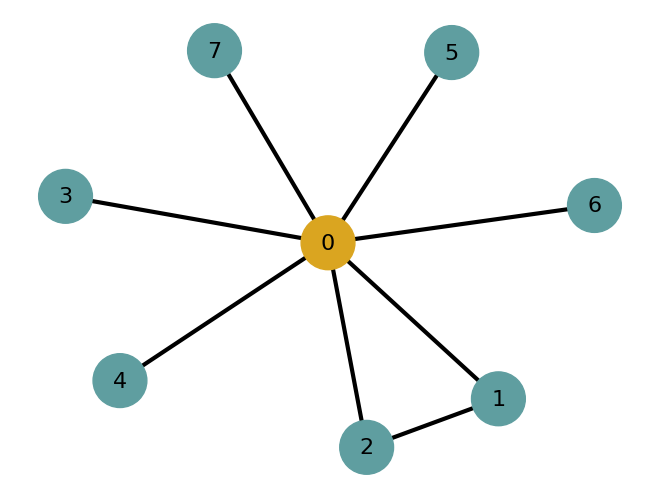

this is your first stable


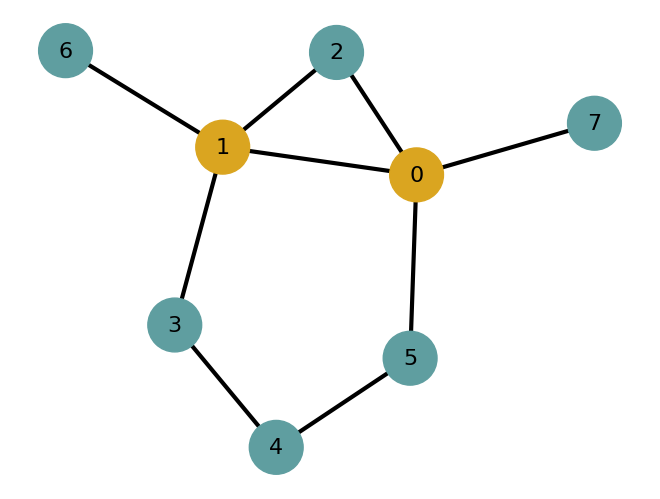

NN is 5
total util stable is 84.76999999999998
total util stable with sum is 84.76999999999998
number of isolated nodes in the stable network 0
diameter of stable network is 3
network utility after disturbance(benefit): 79.57000000000001


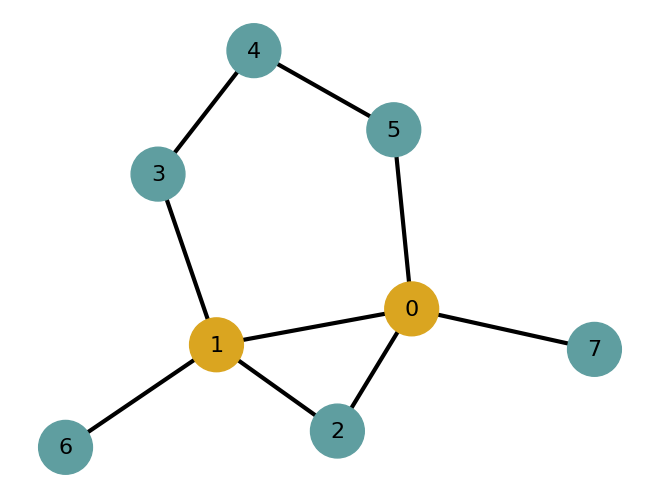

Start efficient designing:
RHS -4.380000000000001
LHS 15.6214
this is m 8
LHS 15.6214
this is m 7
LHS 12.6935
this is m 6
LHS 10.0712
this is m 5
LHS 7.8267
this is m 4
LHS 4.9306
this is m 3
LHS 2.9305
this is m 2
LHS -0.0419
1 2
1 3
1 4
2 3
2 4
number of isolated nodes in the efficient network 0
THIS IS YOUR EFFICIENT NET AFTER DISTURBANCE:


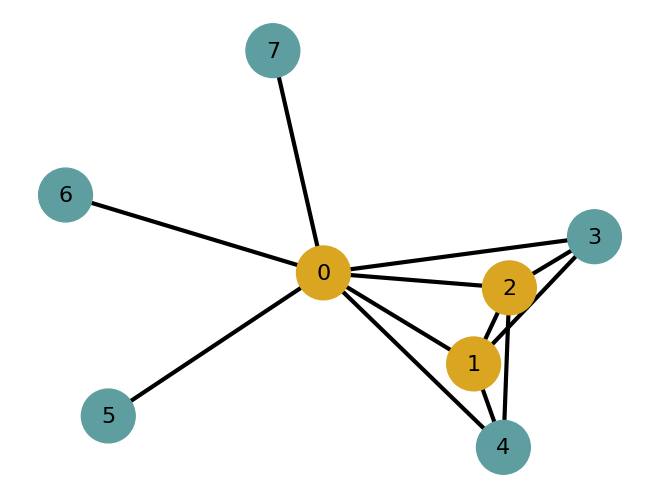

total util new efficient is 86.85999999999999


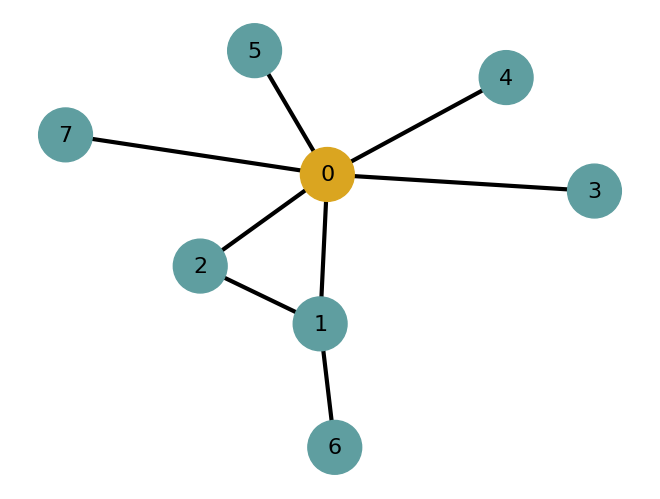

this util: 83.55


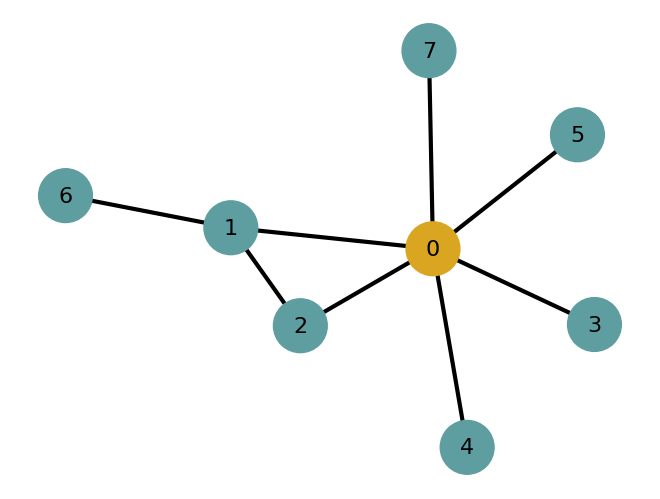

this util: 83.55


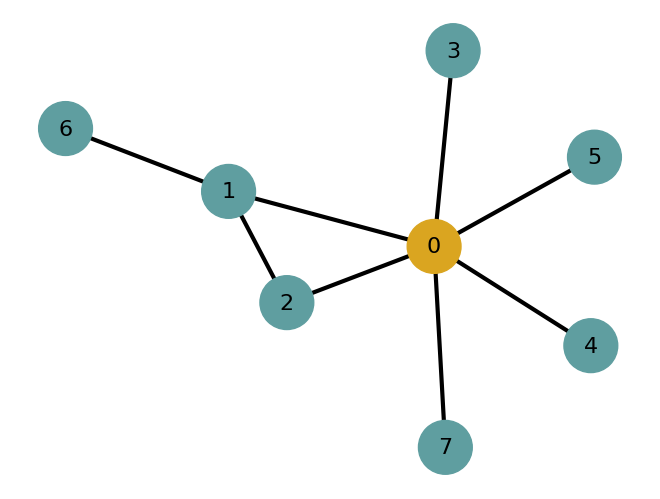

this util: 83.55


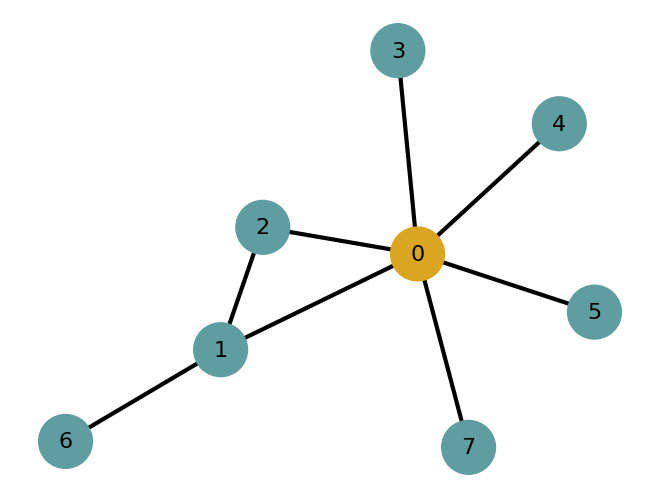

this util: 83.55


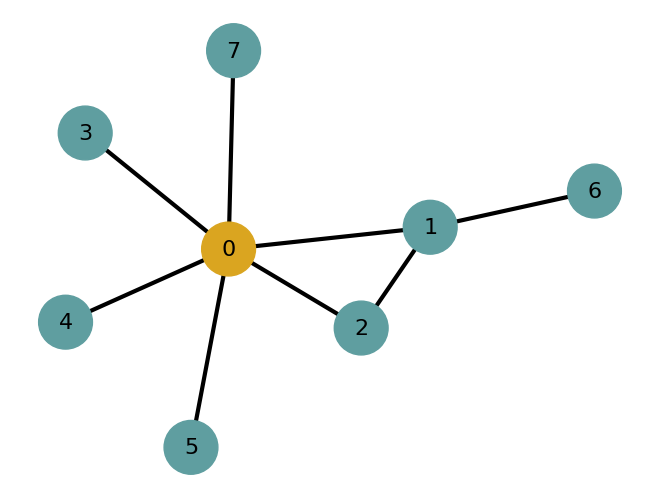

this util: 83.55
My best restabled net with new benefit vector:


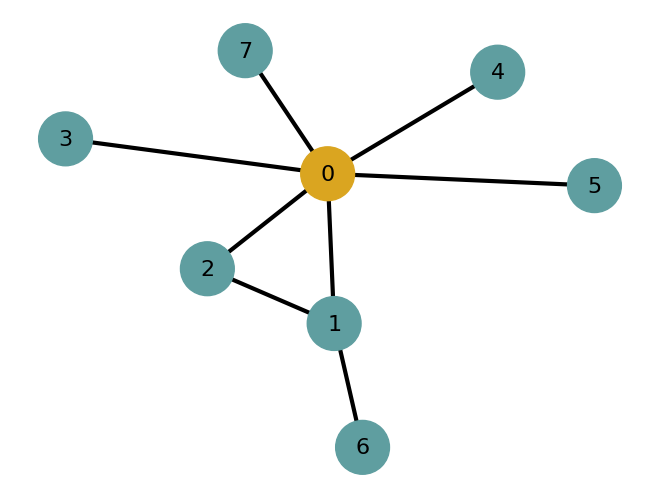

Max network utility after restabilization(benefit): 83.55
benefit restabilization steps: 5
b_rec: 1.0
b_st: 0.0
b_col: 0.0
[80.96, 82.70999999999998, 85.21999999999998, 84.43999999999998, 83.55]
selected nodes are: [4, 3, 0]
new cost vector is [0.0419, 0.0695, 0.52, 1.7693999999999999, 1.9288, 2.1733000000000002, 2.3065, 2.3786]
network utility after disturbance(cost): 80.27


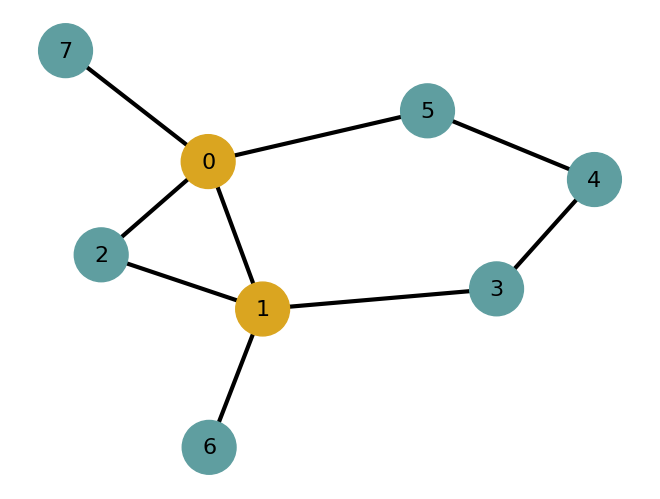

Start efficient designing:
RHS -3.9581
LHS 18.0214
this is m 8
LHS 18.0214
this is m 7
LHS 14.6935
this is m 6
LHS 11.4267
this is m 5
LHS 8.271199999999999
this is m 4
LHS 5.0306
this is m 3
LHS 2.88
this is m 2
LHS -0.0695
1 2
number of isolated nodes in the efficient network 0
THIS IS YOUR EFFICIENT NET AFTER DISTURBANCE:


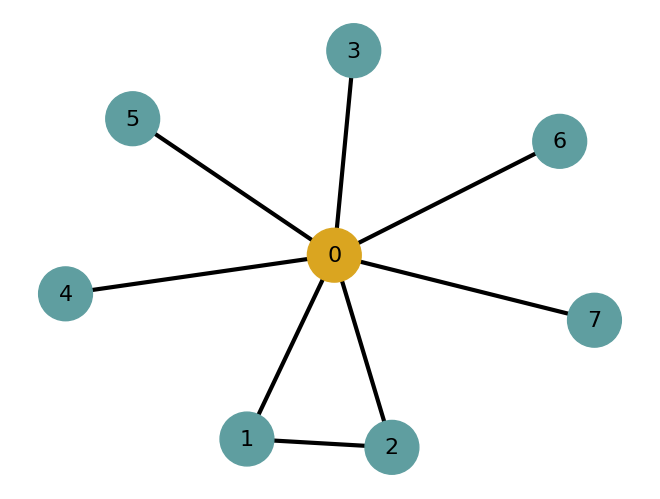

total util new efficient is 87.97
one restabled:


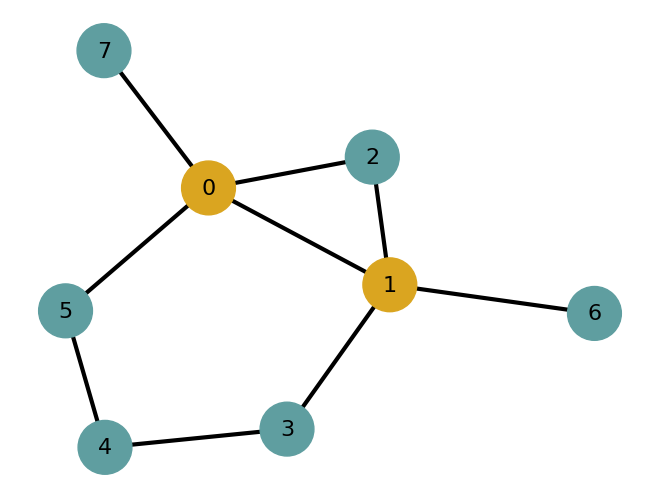

this util: 80.27
one restabled:


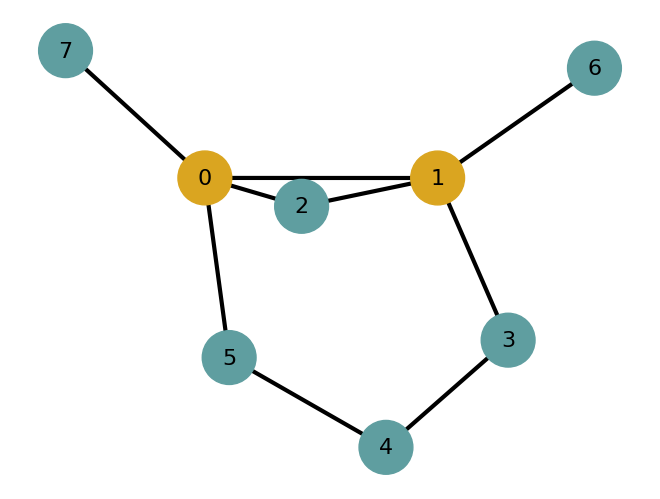

this util: 80.27
one restabled:


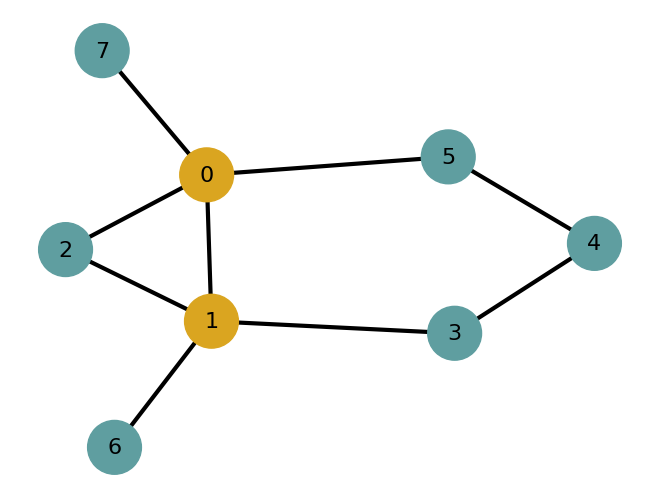

this util: 80.27
one restabled:


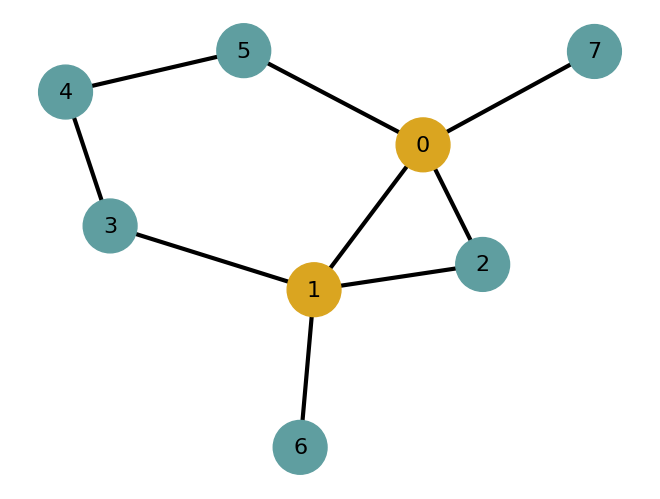

this util: 80.27
one restabled:


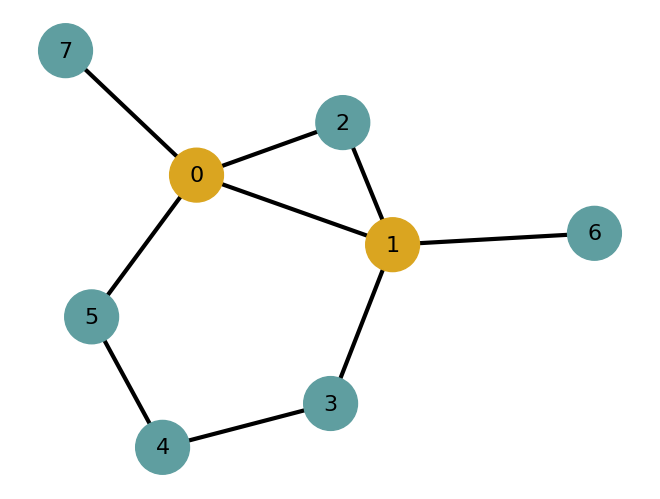

this util: 80.27
My best restabled net with new cost vector:


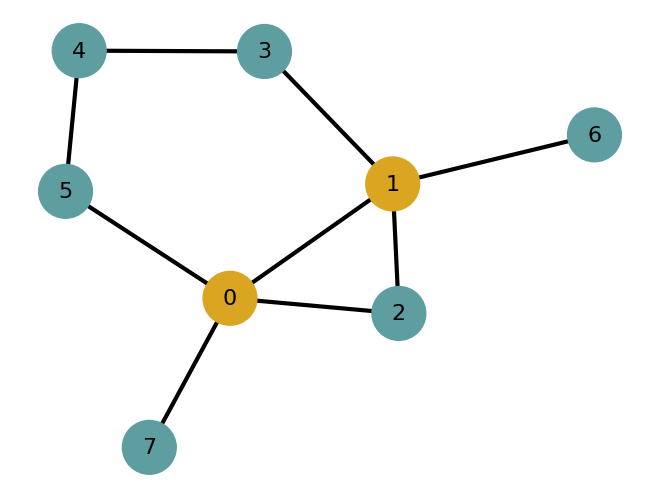

Max network utility after restabilization(cost): 80.27
cost restabilization steps: 0
util_list for cost is: [[80.27, 80.27]]
selected nodes are: [0, 6, 5]
new cost vector is [0.0419, 0.0695, 1.02, 1.0694, 1.1733, 2.3786, 2.4288, 3.0065]
network utility after disturbance(cost): 81.02


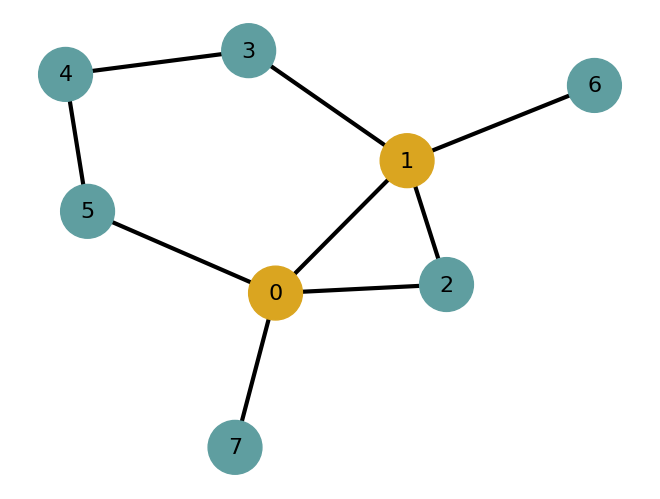

Start efficient designing:
RHS -3.9581
LHS 17.3935
this is m 8
LHS 17.3935
this is m 7
LHS 14.571200000000001
this is m 6
LHS 11.2214
this is m 5
LHS 9.0267
this is m 4
LHS 5.7306
this is m 3
LHS 2.38
this is m 2
LHS -0.0695
number of isolated nodes in the efficient network 0
THIS IS YOUR EFFICIENT NET AFTER DISTURBANCE:


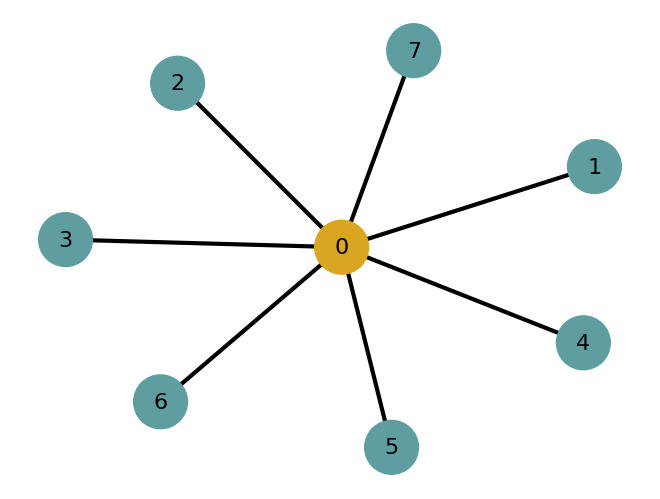

total util new efficient is 87.96
one restabled:


KeyboardInterrupt: 

In [26]:
Cvec_list = [l for l in C_main]
CMS_total =[]
for i in Cvec_list:
    CMS = seperable_cost(i)
    CMS_total.append(CMS)
    
Cvec_average = [sum(sub_list) / len(sub_list) for sub_list in Cvec_list]

d = {'n'+str(i):{"Cvec":list(), "meanCvec":list(), "CMS_total":list(), "b":list()}}
d = {}
all_diameters=[]
all_stable_networks=[]
all_efficient_networks= []
all_utilities =[]
efficient_networks= []
efficient_utility=[]
eff_diameter=[]
eff_degree_cent=[]
eff_max_degree=[]
eff_hubs =[]
best_stables=[]
best_stables_diameter=[]
best_stables_ave_degree=[]
best_stables_max_degree=[]
best_stables_hubs =[]



for i, cvec in enumerate(Cvec_list):    
    all_stables=[]
    
    diameter=[]
    degree= []
    eigen=[]
    between=[]
    cluster=[]
    
    util =[]
    
    all_disturbance_benefit=[]
    all_disturbance_cost=[]
    all_disturbance_cost2=[]
    all_disturbance_benefitcost=[]
    all_disturbance_node=[]
    all_disturbance_edge=[]
    all_disturbance_integ=[]
    
    u2_benefit=[]
    u2_cost=[]
    u2_cost2=[]
    u2_benefitcost=[]
    u2_node=[]
    u2_edge=[]
    u2_integ=[]
    
    u2_cost_std=[]
    u2_cost2_std=[]
    u2_benefitcost_std=[]
    u2_node_std=[]
    u2_edge_std=[]
    u2_integ_std=[]
    
    all_restabled_benefit=[]
    all_restabled_cost=[]
    all_restabled_cost2=[]
    all_restabled_benefitcost=[]
    all_restabled_node=[]
    all_restabled_edge=[]
    all_restabled_integ=[]
    
    u3_benefit=[]
    u3_cost=[]
    u3_cost2=[]
    u3_benefitcost=[]
    u3_node=[]
    u3_edge=[]
    u3_integ=[]
    
#     u3_benefit_std=[]
    u3_cost_std=[]
    u3_cost2_std=[]
    u3_benefitcost_std=[]
    u3_node_std=[]
    u3_edge_std=[]
    u3_integ_std=[]
    
    steps_benefit=[]
    steps_cost=[]
    steps_cost2=[]
    steps_benefitcost=[]
    steps_node=[]
    steps_edge=[]
    steps_integ=[]
    
    recoveryBU_Tlist= []
    recoveryCU_Tlist= []
    recoveryCU_Tlist2= []
    recoveryBCU_Tlist= []
    recoveryNU_Tlist= []
    recoveryEU_Tlist= []
    recoveryIU_Tlist= []
    
    vis_list_b=[]
    vis_list_c=[]
    vis_list_c2=[]
    vis_list_bc=[]
    vis_list_n=[]
    vis_list_e=[]
    vis_list_i=[]
    
    b_r=[]
    b_s=[]
    b_c=[]
    c_r=[]
    c_s=[]
    c_c=[]
    c_r2=[]
    c_s2=[]
    c_c2=[]
    bc_r=[]
    bc_s=[]
    bc_c=[]
    n_r=[]
    n_s=[]
    n_c=[]
    e_r=[]
    e_s=[]
    e_c=[]
    i_r=[]
    i_s=[]
    i_c=[]

    G1,m=seperable_efficient_network(b,cvec)
    efficient_networks.append(G1)
    all_efficient_networks.append(G1)
    eff_diameter.append(nx.diameter(G1))
    degree_cent1=nx.degree_centrality(G1)
    ave_degree_cent1 = (sum(degree_cent1.values()) / len(degree_cent1))
    eff_degree_cent.append(ave_degree_cent1)
    eff_max_degree.append(max(nx.degree_centrality(G1)))
    #B=nx.degree(G1)
    X=0
    degrees0 = [val for (node, val) in nx.degree(G1)]
    for each in degrees0:
        if each >=5:
            X=X+1
    eff_hubs.append(X)
        
    L=all_utils_general(G1,b,CMS_total[i])
    efficient_utility.append(sum(L))        
    print("efficient appearance:")
    print("total util eff is", sum(L))
    draw(G1)
    
       
    while len(all_stables)<5:        
#         G_in=nx.erdos_renyi_graph(len(cvec),0.1)
        G_in=nx.circulant_graph(len(cvec), [1])
        G,NN,G_T=find_stable_network_general(G_in,b,CMS_total[i],depth=3, N=1000, M=1)
#         G,NN,G_T=find_stable_network_general_barg(G_in,b,CMS_total[i],depth=3,N=500,M1=1,M2=1)
        giant = max(connected_component_subgraphs(G), key=len)
        check = 0
        if len(all_stables)==0:
            print('this is your first stable')
            all_stables.append(giant)
            L4=all_utils_general(giant,b,CMS_total[i])
            st_u= sum(L4)
            util.append(st_u)
            
            all_stable_networks.append(giant)
            draw(giant)  
            print("NN is", NN)
            print("total util stable is", total_utility(giant))
            print("total util stable with sum is", st_u)
            print('number of isolated nodes in the stable network',len(cvec)-len(giant.nodes()))
            print('diameter of stable network is', nx.diameter(giant))
            
            
            disb = Disturbance_b(giant, b, cvec)
            disc = Disturbance_c(giant, b, cvec)
            disc2 = Disturbance_c2(giant, b, cvec)
            disbc = Disturbance_BC(giant, b, cvec)
            disn = Disturbance_node(giant, b, cvec)
            dise = Disturbance_edge(giant, b, cvec)
            disi = Disturbance_all(giant, b, cvec)
            
            b_u2, b_G2, b_u3, b_G3, NN1, recoveryBU_list, ulb, b_rec, b_st, b_col= disb.benefit_disturbance()
            print(recoveryBU_list)
            C_list, C_G2, C_u2_L, C_G3, C_u3_L, NN2, C_recovery_t, C_u2, C_u3, C_std_u2, C_std_u3, ulc,c_rec, c_st, c_col= disc.cost_disturbance()
            C_list_2, C_G2_2, C_u2_L_2, C_G3_2, C_u3_L_2, NN2_2, C_recovery_t_2, C_u2_2, C_u3_2, C_std_u2_2, C_std_u3_2,ulc_2,c_rec_2, c_st_2, c_col_2= disc2.cost_disturbance2()
            bC_list, BC_G2, BC_u2_L, BC_G3, BC_u3_L, NN5, BC_recovery_t, BC_u2, BC_u3, BC_std_u2, BC_std_u3,ulbc, bc_rec, bc_st, bc_col= disbc.benefitcost_disturbance()
            N_list, N_G2, N_u2_L, N_G3, N_u3_L, NN4, N_recovery_t, N_u2, N_u3, N_std_u2, N_std_u3,uln, n_rec, n_st, n_col= disn.node_disturbance()
            E_list, E_G2, E_u2_L, E_G3, E_u3_L, NN3, E_recovery_t, E_u2, E_u3, E_std_u2, E_std_u3,ule, e_rec, e_st, e_col= dise.edge_disturbance()
            integ_list, integ_G2, integ_u2_L, integ_G3, integ_u3_L, NN6, I_recovery_t, integ_u2, integ_u3, integ_std_u2, integ_std_u3, uli, i_rec, i_st, i_col= disi.all_disturbance()
            
            ulb.insert(0, st_u)
            print('new ulb with u1 added:', ulb)
            vis_list_b.append(ulb)

            for each in ulc:
                each.insert(0, st_u)
            print('new ulc with u1 added:', ulc)
            vis_list_c.append(ulc)

            for each in ulc_2:
                each.insert(0, st_u)
            print('new ulc2 with u1 added:', ulc_2)
            vis_list_c2.append(ulc_2)

            for each in ulbc:
                each.insert(0, st_u)
            print('new ulbc with u1 added:', ulbc)
            vis_list_bc.append(ulbc)


            for each in uln:
                each.insert(0, st_u)
            print('new uln with u1 added:', uln)
            vis_list_n.append(uln)

            for each in ule:
                each.insert(0, st_u)
            print('new ule with u1 added:', ule)
            vis_list_e.append(ule)

            for each in uli:
                each.insert(0, st_u)
            print('new ulbc with u1 added:', uli)
            vis_list_i.append(uli)

            steps_benefit.append(NN1)
            steps_cost.append(NN2)
            steps_cost2.append(NN2_2)
            steps_benefitcost.append(NN5)
            steps_node.append(NN4)
            steps_edge.append(NN3)
            steps_integ.append(NN6)

            recoveryBU_Tlist.append(recoveryBU_list)
            recoveryCU_Tlist.append(C_recovery_t)
            recoveryCU_Tlist2.append(C_recovery_t_2)
            recoveryBCU_Tlist.append(BC_recovery_t)
            recoveryNU_Tlist.append(N_recovery_t)
            recoveryEU_Tlist.append(E_recovery_t)
            recoveryIU_Tlist.append(I_recovery_t)


            all_disturbance_benefit.append(b_G2)
            u2_benefit.append(b_u2)
            all_restabled_benefit.append(b_G3)
            u3_benefit.append(b_u3)

            all_disturbance_cost.append(C_G2)
            u2_cost.append(C_u2)
            all_restabled_cost.append(C_G3)
            u3_cost.append(C_u3)

            all_disturbance_cost2.append(C_G2_2)
            u2_cost2.append(C_u2_2)
            all_restabled_cost2.append(C_G3_2)
            u3_cost2.append(C_u3_2)

            all_disturbance_benefitcost.append(BC_G2)
            u2_benefitcost.append(BC_u2)
            all_restabled_benefitcost.append(BC_G3)
            u3_benefitcost.append(BC_u3)

            all_disturbance_node.append(N_G2)
            u2_node.append(N_u2)
            all_restabled_node.append(N_G3)
            u3_node.append(N_u3)

            all_disturbance_edge.append(E_G2)
            u2_edge.append(E_u2)
            all_restabled_edge.append(E_G3)
            u3_edge.append(E_u3)
            
            all_disturbance_integ.append(integ_G2)
            u2_integ.append(integ_u2)
            all_restabled_integ.append(integ_G3)
            u3_integ.append(integ_u3)
            
            
            u2_cost_std.append(C_std_u2)
            u2_cost2_std.append(C_std_u2_2)
            u2_benefitcost_std.append(BC_std_u2)
            u2_node_std.append(N_std_u2)
            u2_edge_std.append(E_std_u2)
            u2_integ_std.append(integ_std_u2)

#             u3_benefit_std.append(C_std_u2)
            u3_cost_std.append(C_std_u3)
            u3_cost2_std.append(C_std_u3_2)
            u3_benefitcost_std.append(BC_std_u3)
            u3_node_std.append(N_std_u3)
            u3_edge_std.append(E_std_u3)
            u3_integ_std.append(integ_std_u3)

            b_r.append(b_rec)
            b_s.append(b_st)
            b_c.append(b_col)
            
            c_r.append(c_rec)
            c_s.append(c_st)
            c_c.append(c_col)
            

            c_r2.append(c_rec_2)
            c_s2.append(c_st_2)
            c_c2.append(c_col_2)

            bc_r.append(bc_rec)
            bc_s.append(bc_st)
            bc_c.append(bc_col)
            
            n_r.append(n_rec)
            n_s.append(n_st)
            n_c.append(n_col)
            
            e_r.append(e_rec)
            e_s.append(e_st)
            e_c.append(e_col)
            
            i_r.append(i_rec)
            i_s.append(i_st)
            i_c.append(i_col)
            
            TO= time.time()+120          
        else:
            print("this is another stable")
            if time.time()<TO:
                for z in range(len(all_stables)) :
                    if nx.is_isomorphic(giant, all_stables[z])==True:
                        check =1
                while check ==0:
                    check = 1
                    all_stables.append(giant)
                    L4=all_utils_general(giant,b,CMS_total[i])
                    st_u= sum(L4)
                    util.append(st_u)
                    all_stable_networks.append(giant)

                    draw(giant)  
                    print("NN is", NN)
                    print("total util stable is", total_utility(giant))
                    print("total util stable with sum is", st_u)
                    print('number of isolated nodes in the stable network',len(cvec)-len(giant.nodes()))
                    print('diameter of stable network is', nx.diameter(giant))
                    
                    
                    
                    disb = Disturbance_b(giant, b, cvec)
                    disc = Disturbance_c(giant, b, cvec)
                    disc2 = Disturbance_c2(giant, b, cvec)
                    disbc = Disturbance_BC(giant, b, cvec)
                    disn = Disturbance_node(giant, b, cvec)
                    dise = Disturbance_edge(giant, b, cvec)
                    disi = Disturbance_all(giant, b, cvec)

                    b_u2, b_G2, b_u3, b_G3, NN1, recoveryBU_list, ulb, b_rec, b_st, b_col= disb.benefit_disturbance()
                    print(recoveryBU_list)
                    C_list, C_G2, C_u2_L, C_G3, C_u3_L, NN2, C_recovery_t, C_u2, C_u3, C_std_u2, C_std_u3, ulc,c_rec, c_st, c_col= disc.cost_disturbance()
                    C_list_2, C_G2_2, C_u2_L_2, C_G3_2, C_u3_L_2, NN2_2, C_recovery_t_2, C_u2_2, C_u3_2, C_std_u2_2, C_std_u3_2,ulc_2,c_rec_2, c_st_2, c_col_2= disc2.cost_disturbance2()
                    bC_list, BC_G2, BC_u2_L, BC_G3, BC_u3_L, NN5, BC_recovery_t, BC_u2, BC_u3, BC_std_u2, BC_std_u3,ulbc, bc_rec, bc_st, bc_col= disbc.benefitcost_disturbance()
                    N_list, N_G2, N_u2_L, N_G3, N_u3_L, NN4, N_recovery_t, N_u2, N_u3, N_std_u2, N_std_u3,uln, n_rec, n_st, n_col= disn.node_disturbance()
                    E_list, E_G2, E_u2_L, E_G3, E_u3_L, NN3, E_recovery_t, E_u2, E_u3, E_std_u2, E_std_u3,ule, e_rec, e_st, e_col= dise.edge_disturbance()
                    integ_list, integ_G2, integ_u2_L, integ_G3, integ_u3_L, NN6, I_recovery_t, integ_u2, integ_u3, integ_std_u2, integ_std_u3, uli, i_rec, i_st, i_col= disi.all_disturbance()

                    ulb.insert(0, st_u)
                    print('new ulb with u1 added:', ulb)
                    vis_list_b.append(ulb)
                    
                    for each in ulc:
                        each.insert(0, st_u) 
                    print('new ulc with u1 added:', ulc)
                    vis_list_c.append(ulc)

                    for each in ulc_2:
                        each.insert(0, st_u)
                    print('new ulc2 with u1 added:', ulc_2)
                    vis_list_c2.append(ulc)
                    
                    for each in ulbc:
                        each.insert(0, st_u)
                    print('new ulbc with u1 added:', ulbc)
                    vis_list_bc.append(ulbc)

                    for each in uln:
                        each.insert(0, st_u)
                    print('new uln with u1 added:', uln)
                    vis_list_n.append(uln)

                    for each in ule:
                        each.insert(0, st_u)
                    print('new ule with u1 added:', ule)
                    vis_list_e.append(ule)

                    
                    for each in uli:
                        each.insert(0, st_u)
                    print('new ulbc with u1 added:', uli)
                    vis_list_i.append(uli)

                    steps_benefit.append(NN1)
                    steps_cost.append(NN2)
                    steps_cost2.append(NN2_2)
                    steps_benefitcost.append(NN5)
                    steps_node.append(NN4)
                    steps_edge.append(NN3)
                    steps_integ.append(NN6)

                    recoveryBU_Tlist.append(recoveryBU_list)
                    recoveryCU_Tlist.append(C_recovery_t)
                    recoveryCU_Tlist2.append(C_recovery_t_2)
                    recoveryBCU_Tlist.append(BC_recovery_t)
                    recoveryNU_Tlist.append(N_recovery_t)
                    recoveryEU_Tlist.append(E_recovery_t)
                    recoveryIU_Tlist.append(I_recovery_t)

                    all_disturbance_benefit.append(b_G2)
                    u2_benefit.append(b_u2)
                    all_restabled_benefit.append(b_G3)
                    u3_benefit.append(b_u3)

                    all_disturbance_cost.append(C_G2)
                    u2_cost.append(C_u2)
                    all_restabled_cost.append(C_G3)
                    u3_cost.append(C_u3)
                    
                    all_disturbance_cost2.append(C_G2_2)
                    u2_cost2.append(C_u2_2)
                    all_restabled_cost2.append(C_G3_2)
                    u3_cost2.append(C_u3_2)

                    all_disturbance_benefitcost.append(BC_G2)
                    u2_benefitcost.append(BC_u2)
                    all_restabled_benefitcost.append(BC_G3)
                    u3_benefitcost.append(BC_u3)

                    all_disturbance_node.append(N_G2)
                    u2_node.append(N_u2)
                    all_restabled_node.append(N_G3)
                    u3_node.append(N_u3)

                    all_disturbance_edge.append(E_G2)
                    u2_edge.append(E_u2)
                    all_restabled_edge.append(E_G3)
                    u3_edge.append(E_u3)
                    
                    all_disturbance_integ.append(integ_G2)
                    u2_integ.append(integ_u2)
                    all_restabled_integ.append(integ_G3)
                    u3_integ.append(integ_u3)


                    u2_cost_std.append(C_std_u2)
                    u2_cost2_std.append(C_std_u2_2)
                    u2_benefitcost_std.append(BC_std_u2)
                    u2_node_std.append(N_std_u2)
                    u2_edge_std.append(E_std_u2)
                    u2_integ_std.append(integ_std_u2)

        #             u3_benefit_std.append(C_std_u2)
                    u3_cost_std.append(C_std_u3)
                    u3_cost2_std.append(C_std_u3_2)
                    u3_benefitcost_std.append(BC_std_u3)
                    u3_node_std.append(N_std_u3)
                    u3_edge_std.append(E_std_u3)
                    u3_integ_std.append(integ_std_u3)

                    b_r.append(b_rec)
                    b_s.append(b_st)
                    b_c.append(b_col)
                    c_r.append(c_rec)
                    c_s.append(c_st)
                    c_c.append(c_col)
                    
                    c_r2.append(c_rec_2)
                    c_s2.append(c_st_2)
                    c_c2.append(c_col_2)
                    
                    bc_r.append(bc_rec)
                    bc_s.append(bc_st)
                    bc_c.append(bc_col)
                    n_r.append(n_rec)
                    n_s.append(n_st)
                    n_c.append(n_col)
                    e_r.append(e_rec)
                    e_s.append(e_st)
                    e_c.append(e_col)
                    
                      
                    i_r.append(i_rec)
                    i_s.append(i_st)
                    i_c.append(i_col)
            
            else: break
                    
    net_characteristics(all_stables)
    print("vis b list is", vis_list_b)
    print("vis c list is", vis_list_c)
    print("vis bc list is", vis_list_bc)
    print("vis n list is", vis_list_n)
    print("vis e list is", vis_list_e)
    print("vis i list is", vis_list_i)
    
    #Comparison between best_stable and efficient:
    A=sorted(all_stables, key=total_utility, reverse=True)
    best_stables.append(A[0])
    best_stables_diameter.append(nx.diameter(A[0]))
    degree_cent3=nx.degree_centrality(A[0])
    ave_degree_cent3 = sum(degree_cent3.values()) / len(degree_cent3)
    best_stables_ave_degree.append(ave_degree_cent3)
    best_stables_max_degree.append(max(nx.degree_centrality(A[0])))
    
    print("best stable appearance:")
    node_labels = nx.get_node_attributes(giant,'utility')
    color_map2=draw(A[0])
    best_stables_hubs.append(color_map2.count('goldenrod'))

    d['n'+str(i)] = {"Cvec":cvec, "Cvec_ave":Cvec_average[i],
                     "CMS_total":CMS_total[i], 
                     "b":b, "mean_b":mean(b), 
                     "efficient":efficient_networks,"stable_networks":all_stables, 
                     "iteration_len":len(all_stables),"best_stable":best_stables[i], 
                     
                     'benefit_disturbed':all_disturbance_benefit, 'cost_disturbed':all_disturbance_cost,
                     'cost_disturbed2':all_disturbance_cost2,
                     'node_disturbed':all_disturbance_node, 'edge_disturbed':all_disturbance_edge,
                     'benefitCost_disturbed':all_disturbance_benefitcost,
                     'integ_disturbed':all_disturbance_integ,
                     
                     'benefit_restabled':all_restabled_benefit, 'cost_restabled':all_restabled_cost,
                     'cost_restabled2':all_restabled_cost2,
                     'node_restabled':all_restabled_node, 'edge_restabled':all_restabled_edge,
                     'benefitCost_restabled':all_restabled_benefitcost,
                     'integ_restabled':all_restabled_integ,

                     "eff_util":efficient_utility[i], "stables_utility":util,
                     "best_stable_util":max(util),
                     "stables_min_util": min(util),
                     "stables_mean_util": mean(util),
                     
                     'U2_b':u2_benefit, 'U2_c':u2_cost, 'U2_c2':u2_cost2, 
                     'U2_bc':u2_benefitcost,'U2_e':u2_edge,'U2_n':u2_node, 'U2_i':u2_integ,
                     
                     'U3_b':u3_benefit, 'U3_c':u3_cost, 'U3_c2':u3_cost2, 
                     'U3_bc':u3_benefitcost,'U3_e':u3_edge,'U3_n':u3_node, 'U3_i':u3_integ,                    
                     
                     
                     "disturbed_mean_util_benefit": mean(u2_benefit), "restabled_mean_util_benefit": mean(u3_benefit),
                     'benefit_steps': mean(steps_benefit),'benefit_steps_list': steps_benefit,
                     "Benefit_recovery_Tlist": recoveryBU_Tlist,
                     'benefit_util_list_visual':vis_list_b, 'benefit_recovery_rate': mean(b_r),
                     'benefit_stable_rate': mean(b_s), 'benefit_collapse_rate': mean(b_c), 
                     
                     
                     "disturbed_mean_util_cost": mean(u2_cost), "restabled_mean_util_cost": mean(u3_cost),
                     'cost_steps': mean(steps_cost), 'cost_steps_list': steps_cost,
                     "Cost_recovery_Tlist": recoveryCU_Tlist,
                     'cost_util_list_visual':vis_list_c, 'cost_recovery_rate': mean(c_r),
                     'cost_stable_rate': mean(c_s), 'cost_collapse_rate': mean(c_c),
                     
                     "disturbed_mean_util_cost2": mean(u2_cost2), "restabled_mean_util_cost2": mean(u3_cost2),
                     'cost_steps2': mean(steps_cost2),'cost2_steps_list': steps_cost2,
                     "Cost_recovery_Tlist2": recoveryCU_Tlist2,
                     'cost_util_list_visual2':vis_list_c2, 'cost_recovery_rate2': mean(c_r2),
                     'cost_stable_rate2': mean(c_s2), 'cost_collapse_rate2': mean(c_c2),
                     
                     "disturbed_mean_util_benefitCost": mean(u2_benefitcost), 
                     "restabled_mean_util_benefitCost": mean(u3_benefitcost),
                     'benefitCost_steps': mean(steps_benefitcost),'benefitCost_steps_list':steps_benefitcost,
                     "BenefitCost_recovery_Tlist": recoveryBCU_Tlist,
                     'benefitcost_util_list_visual':vis_list_bc,
                     'benefitcost_recovery_rate': mean(bc_r),
                     'benefitcost_stable_rate': mean(bc_s), 'benefitcost_collapse_rate': mean(bc_c),
                     
                     "disturbed_mean_util_node": mean(u2_node),"restabled_mean_util_node": mean(u3_node),
                      'node_steps': mean(steps_node),'node_steps_list':steps_node,
                     "Node_recovery_Tlist": recoveryNU_Tlist,
                     'node_util_list_visual':vis_list_n,'node_recovery_rate': mean(n_r),
                     'node_stable_rate': mean(n_s), 'node_collapse_rate': mean(n_c),
                     
                     "disturbed_mean_util_edge": mean(u2_edge),"restabled_mean_util_edge": mean(u3_edge),
                     'edge_steps': mean(steps_edge),'edge_steps_list':steps_edge,
                     "Edge_recovery_Tlist": recoveryEU_Tlist,
                     'edge_util_list_visual':vis_list_e, 'edge_recovery_rate': mean(e_r),
                     'edge_stable_rate': mean(e_s), 'edge_collapse_rate': mean(e_c),
                     
                     
                     "disturbed_mean_util_integ": mean(u2_integ),"restabled_mean_util_integ": mean(u3_integ),
                     'integ_steps': mean(steps_integ),'integ_steps_list':steps_integ,
                     "integ_recovery_Tlist": recoveryIU_Tlist,
                     'integ_util_list_visual':vis_list_i, 'integ_recovery_rate': mean(i_r),
                     'integ_stable_rate': mean(i_s), 'integ_collapse_rate': mean(i_c),
                     
                     'std_u2_C':u2_cost_std, 'std_u2_C2':u2_cost2_std, 'std_u2_BC':u2_benefitcost_std,
                     'std_u2_N':u2_node_std, 'std_u2_E':u2_edge_std, 'std_u2_I':u2_integ_std,
                     
                     'std_u3_C':u3_cost_std, 'std_u3_C2':u3_cost2_std, 'std_u3_BC':u3_benefitcost_std,
                     'std_u3_N':u3_node_std, 'std_u3_E':u3_edge_std, 'std_u3_I':u3_integ_std,
                    
                     
                     "eff_diameter": eff_diameter[i], 
                     "best_stable_diameter":best_stables_diameter[i],"stables_ave_diameter":mean(diameter), 
                     "stables_max_diameter":max(diameter), 
                    
                     "eff_degree":eff_degree_cent[i],"stables_ave_degree":mean(degree), 
                     "best_stable_ave_degree":best_stables_ave_degree[i],
                     
                     "eff_Max_degree":eff_max_degree[i], "best_stable_max_degree":best_stables_max_degree[i],
                     
                     "stables_ave_eigen":mean(eigen), 
                     "stables_ave_between":mean(between), "stables_ave_cluster":mean(cluster),
                      
                      "eff_hub_count":eff_hubs[i],
                     "best_stable_hub_count": best_stables_hubs[i],
                                         
                     "PoA":efficient_utility[i]/min(util), "PoS":efficient_utility[i]/max(util), 
                     "intervention_opp": min(util)/max(util), 
                     "improvement_opp%": ((max(util)-min(util))/min(util))*100}

In [ ]:
print("#all stable networks", len(all_stable_networks))
pd.set_option('display.max_rows', None)
df= pd.DataFrame(d)
df2 = df.T
df

In [84]:
u1_std=np.std(df2['stables_utility'][0])
u1_mean=mean(df2['stables_utility'][0])
print('u1:', u1_mean, ',', u1_std)

benefit_u2_std=np.std(df2['U2_b'][0])
benefit_u2_mean=mean(df2['U2_b'][0])
print('u2 for benefit :', benefit_u2_mean, ',', benefit_u2_std)
benefit_steps_std=np.std(df2['benefit_steps_list'][0])

cost_u2_std=np.std(df2['U2_c'][0])
cost_u2_mean=mean(df2['U2_c'][0])
print('u2 for cost :', cost_u2_mean, ',', cost_u2_std)
cost_steps_std=np.std(df2['cost_steps_list'][0])

cost2_u2_std=np.std(df2['U2_c2'][0])
cost2_u2_mean=mean(df2['U2_c2'][0])
print('u2 for cost2 :', cost2_u2_mean, ',', cost2_u2_std)
cost2_steps_std=np.std(df2['cost2_steps_list'][0])

benefitcost_u2_std=np.std(df2['U2_bc'][0])
benefitcost_u2_mean=mean(df2['U2_bc'][0])
print('u2 for benefitcost :', benefitcost_u2_mean, ',', benefitcost_u2_std)
benefitcost_steps_std=np.std(df2['benefitCost_steps_list'][0])

node_u2_std=np.std(df2['U2_n'][0])
node_u2_mean=mean(df2['U2_n'][0])
print('u2 for node :', node_u2_mean, ',', node_u2_std)
node_steps_std=np.std(df2['node_steps_list'][0])

edge_u2_std=np.std(df2['U2_e'][0])
edge_u2_mean=mean(df2['U2_e'][0])
print('u2 for edge :', edge_u2_mean, ',', edge_u2_std)
edge_steps_std=np.std(df2['edge_steps_list'][0])

integ_u2_std=np.std(df2['U2_i'][0])
integ_u2_mean=mean(df2['U2_i'][0])
print('u2 for edge :', integ_u2_mean, ',', integ_u2_std)
integ_steps_std=np.std(df2['integ_steps_list'][0])

benefit_u3_std=np.std(df2['U3_b'][0])
benefit_u3_mean=mean(df2['U3_b'][0])
print('u3 for benefit :', benefit_u3_mean, ',', benefit_u3_std)

cost_u3_std=np.std(df2['U3_c'][0])
cost_u3_mean=mean(df2['U3_c'][0])
print('u3 for cost :', cost_u3_mean, ',', cost_u3_std)

cost2_u3_std=np.std(df2['U3_c2'][0])
cost2_u3_mean=mean(df2['U3_c2'][0])
print('u3 for cost2 :', cost2_u3_mean, ',', cost2_u3_std)

benefitcost_u3_std=np.std(df2['U3_bc'][0])
benefitcost_u3_mean=mean(df2['U3_bc'][0])
print('u3 for benefitcost :', benefitcost_u3_mean, ',', benefitcost_u3_std)

node_u3_std=np.std(df2['U3_n'][0])
node_u3_mean=mean(df2['U3_n'][0])
print('u3 for node :', node_u3_mean, ',', node_u3_std)

edge_u3_std=np.std(df2['U3_e'][0])
edge_u3_mean=mean(df2['U3_e'][0])
print('u3 for edge :', edge_u3_mean, ',', edge_u3_std)


integ_u3_std=np.std(df2['U3_i'][0])
integ_u3_mean=mean(df2['U3_i'][0])
print('u3 for edge :', integ_u3_mean, ',', integ_u3_std)

u1: 89.118 , 2.3058482170342436
u2 for benefit : 84.11800000000001 , 2.4070180722213146
u2 for cost : 83.83489655172414 , 2.3248439774788126
u2 for cost2 : 84.63848275862068 , 3.288527238135211
u2 for benefitcost : 79.04110344827586 , 2.598047454894439
u2 for node : 61.205448275862075 , 5.0307677904308665
u2 for edge : 79.13668965517242 , 2.062247006499099
u2 for edge : 40.95655172413793 , 3.629920502400231
u3 for benefit : 88.55600000000001 , 1.7656794726110365
u3 for cost : 84.1663448275862 , 1.7443284089005433
u3 for cost2 : 84.85455172413793 , 3.425900635987212
u3 for benefitcost : 82.91186206896552 , 0.3373722050736296
u3 for node : 67.22089655172414 , 1.4081502797868368
u3 for edge : 89.96786206896552 , 0.8843585286151526
u3 for edge : 60.11048275862069 , 0.646047770493644


In [1]:
# plt.figure()
# plt.subplot(1,3,1)

X= (1, 2, 2+df2['benefit_steps'][0])
Y=[u1_mean, benefit_u2_mean, benefit_u3_mean]
plt.scatter(X[0], Y[0], label = 'benefit', marker='s',s=100, c='b')
plt.scatter(X[1], Y[1], label = 'benefit', marker='o', s=150, c='b')
plt.scatter(X[2], Y[2], label = 'benefit', marker='*', s=150, c='b')
plt.errorbar(X, Y, yerr = [u1_std, benefit_u2_std, benefit_u3_std],
             xerr = [0, 0, benefit_steps_std],ecolor = 'red', capsize=3) 
plt.xlabel('steps')
# plt.ylabel('utilities')
plt.title('network performance: benefit disturbance')
# annotations=["stable", 'disturbed', 're-stabled']
# for i, label in enumerate(annotations):
#     plt.annotate(label, (X[i], Y[i]))
plt.show()


plt.figure()
# plt.subplot(1,3,2)
X= (1, 2, 2+df2['cost_steps'][0])
# plt.scatter(X, [u1_mean, cost_u2_mean, cost_u3_mean], label = 'cost', marker=['v','o','*'])
plt.scatter(X[0],u1_mean, label = 'cost', marker='s',s=100, c='b')
plt.scatter(X[1], cost_u2_mean, label = 'cost', marker='o', s=100, c='b')
plt.scatter(X[2], cost_u3_mean, label = 'cost', marker='*', s=150, c='b')
plt.errorbar(X, [u1_mean, cost_u2_mean, cost_u3_mean], yerr = [u1_std, cost_u2_std, cost_u3_std],
             xerr = [0, 0, cost_steps_std],ecolor = 'red', capsize=3) 
plt.xlabel('steps')
plt.ylabel('utilities')
plt.title('network performance: cost disturbance')
# plt.show()


# plt.figure()
# # plt.subplot(121)
# X= (1, 2, 2+df2['cost_steps2'][0])
# Y=[u1_mean, cost2_u2_mean, cost2_u3_mean]
# plt.scatter(X[0], Y[0], label = 'cost2', marker='s',s=100, c='b')
# plt.scatter(X[1], Y[1], label = 'cost2', marker='o',s=100, c='b')
# plt.scatter(X[2], Y[2], label = 'cost2', marker='*',s=150, c='b')
# plt.errorbar(X, Y, yerr = [u1_std,cost2_u2_std, cost2_u3_std],
#              xerr = [0, 0, cost2_steps_std],ecolor = 'red', capsize=3) 
# plt.xlabel('steps')
# plt.ylabel('utilities')
# plt.title('network performance: cost disturbance')
# plt.show()


plt.figure()
# plt.subplot(1,3,3)
X= (1, 2, 2+df2['benefitCost_steps'][0])
Y=[u1_mean, benefitcost_u2_mean, benefitcost_u3_mean]
plt.scatter(X[0], Y[0], label = 'b&c', marker='s',s=100, c='b')
plt.scatter(X[1], Y[1], label = 'b&c', marker='o',s=100, c='b')
plt.scatter(X[2], Y[2], label = 'b&c', marker='*',s=150, c='b')
plt.errorbar(X, Y, yerr = [u1_std, benefitcost_u2_std, benefitcost_u3_std],
             xerr = [0, 0, benefitcost_steps_std],ecolor = 'red', capsize=3) 
plt.xlabel('steps')
# plt.ylabel('utilities')
plt.title('network performance: benefit & cost disturbances')
# plt.show()

plt.figure()
# plt.subplot(2,3,1)
X= (1, 2, 2+df2['node_steps'][0])
Y=[u1_mean, node_u2_mean, node_u3_mean]
plt.scatter(X[0],Y[0] , label = 'node', marker='s',s=100, c='b')
plt.scatter(X[1],Y[1] , label = 'node', marker='o',s=100, c='b')
plt.scatter(X[2],Y[2], label = 'node', marker='*',s=150, c='b')
plt.errorbar(X, Y, yerr = [u1_std, node_u2_std, node_u3_std],
             xerr = [0, 0, node_steps_std], ecolor = 'red', capsize=3)
# plt.xlabel('steps')
plt.ylabel('utilities')
plt.title('network performance: node disturbance')
# annotations=["stable", 'disturbed', 're-stabled']
# for i, label in enumerate(annotations):
#     plt.annotate(label, (X[i], Y[i]))
# plt.show()


plt.figure()
# plt.subplot(2,3,2)
X= (1, 2, 2+df2['edge_steps'][0])
Y=[u1_mean, edge_u2_mean, edge_u3_mean]
# Y=[df2['stables_utility'][0], df2['U2_b'][0], df2['U3_b'][0]]
plt.scatter(X[0], Y[0], label = 'edge', marker='s',s=100, c='b')
plt.scatter(X[1], Y[1], label = 'edge', marker='o',s=100, c='b')
plt.scatter(X[2], Y[2], label = 'edge', marker='*',s=200, c='b')
plt.errorbar(X, Y, yerr = [u1_std, edge_u2_std, edge_u3_std],
             xerr = [0, 0, edge_steps_std], ecolor = 'red', capsize=3)
# plt.ylabel('utilities')
plt.xlabel('steps')
plt.title('network performance: edge disturbance')
plt.show()


plt.figure()
# plt.subplot(2,3,2)
X= (1, 2, 2+df2['integ_steps'][0])
Y=[u1_mean, integ_u2_mean, integ_u3_mean]
# Y=[df2['stables_utility'][0], df2['U2_b'][0], df2['U3_b'][0]]
plt.scatter(X[0], Y[0], label = 'integ', marker='s',s=100, c='b')
plt.scatter(X[1], Y[1], label = 'integ', marker='o',s=100, c='b')
plt.scatter(X[2], Y[2], label = 'integ', marker='*',s=200, c='b')
plt.errorbar(X, Y, yerr = [u1_std, integ_u2_std, integ_u3_std],
             xerr = [0, 0, integ_steps_std], ecolor = 'red', capsize=3)
# plt.ylabel('utilities')
plt.xlabel('steps')
plt.title('network performance: integrated disturbances')
plt.show()

NameError: name 'df2' is not defined

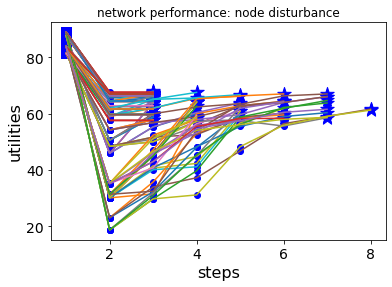

In [43]:
for each in df2['node_util_list_visual']:
    for k in each:
        for Y in k: 
            
            X= list(range(1, len(Y)+1))
            for i in range (len(Y)):
                if i==0:
                    plt.scatter(X[i], Y[i], label = 'edge', marker='s',s=100, c='b')
                elif i<len(Y)-1:
                    plt.scatter(X[i], Y[i], label = 'edge', c='b')
                else:
                    plt.scatter(X[i], Y[i], label = 'edge', marker='*',s=200, c='b')
            plt.plot(X,Y)
plt.xlabel('steps')
plt.ylabel('utilities')
plt.title('network performance: node disturbance')

plt.show()

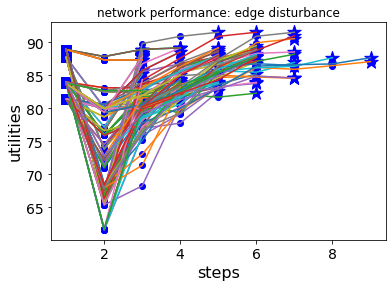

In [44]:
for each in df2['edge_util_list_visual']:
    for k in each:
        for Y in k: 
            X= list(range(1, len(Y)+1))
            for i in range (len(Y)):
                if i==0:
                    plt.scatter(X[i], Y[i], label = 'edge', marker='s',s=100, c='b')
                elif i<len(Y)-1:
                    plt.scatter(X[i], Y[i], label = 'edge', c='b')
                else:
                    plt.scatter(X[i], Y[i], label = 'edge', marker='*',s=200, c='b')
            plt.plot(X,Y)

    plt.xlabel('steps')
    plt.ylabel('utilities')
    plt.title('network performance: edge disturbance')
    plt.show()

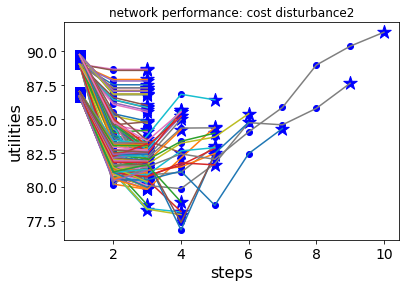

In [157]:
for each in df2['cost_util_list_visual2']:
    for k in each:
        for Y in k: 
            X= list(range(1, len(Y)+1))
            for i in range (len(Y)):
                if i==0:
                    plt.scatter(X[i], Y[i], label = 'edge', marker='s',s=100, c='b')
                elif i<len(Y)-1:
                    plt.scatter(X[i], Y[i], label = 'edge', c='b')
                else:
                    plt.scatter(X[i], Y[i], label = 'edge', marker='*',s=200, c='b')
            plt.plot(X,Y)
            
            plt.xlabel('steps')
            plt.ylabel('utilities')
            plt.title('network performance: cost disturbance2')
    plt.show()

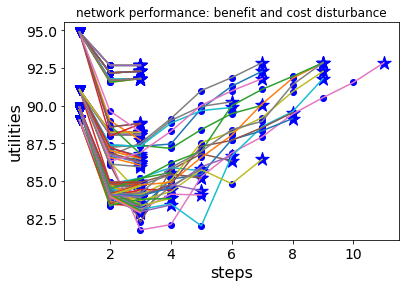

In [88]:
for each in df2['benefitcost_util_list_visual']:
    for k in each:
        for Y in k: 
            X= list(range(1, len(Y)+1))
            for i in range (len(Y)):
                if i==0:
                    plt.scatter(X[i], Y[i], label = 'edge', marker='v',s=100, c='b')
                elif i<len(Y)-1:
                    plt.scatter(X[i], Y[i], label = 'edge', c='b')
                else:
                    plt.scatter(X[i], Y[i], label = 'edge', marker='*',s=200, c='b')
            plt.plot(X,Y)
        
plt.xlabel('steps')
plt.ylabel('utilities')
plt.title('network performance: benefit and cost disturbance')
plt.show()

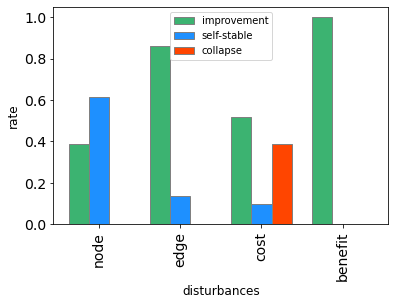

In [63]:
barWidth = 0.25
# fig = plt.subplots(figsize =(12, 8))
recoveryRates=df2[['node_recovery_rate', 'edge_recovery_rate','cost_recovery_rate',
                   'benefit_recovery_rate']].values
stableRates=df2[['node_stable_rate','edge_stable_rate','cost_stable_rate',
                 'benefit_stable_rate']].values
CollapseRates=df2[['node_collapse_rate','edge_collapse_rate',
                   'cost_collapse_rate','benefit_collapse_rate']].values

# Set position of bar on X axis
br1 = np.arange(4)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

for x in recoveryRates:
    plt.bar(br1, x, color ='mediumseagreen', width = barWidth,
        edgecolor ='grey', label ='improvement')
for y in stableRates:
    plt.bar(br2, y, color ='dodgerblue', width = barWidth,
        edgecolor ='grey', label ='self-stable')
for z in CollapseRates:
    plt.bar(br3, z, color ='orangered', width = barWidth,
        edgecolor ='grey', label ='collapse')
 
# Adding Xticks
plt.xlabel('disturbances', fontsize = 12)
plt.ylabel('rate', fontsize = 12)
plt.xticks([r + barWidth for r in range(4)],
        ['node', 'edge', 'cost', 'benefit'], rotation='vertical')
 
plt.legend(loc='upper center')
plt.show()